In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import random
from maad import sound, features
from maad.util import (
    date_parser, plot_correlation_map, 
    plot_features_map, plot_features, false_Color_Spectro
    )

In [105]:
# Set Variables
SPECTRAL_FEATURES = ['MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf', 
                     'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 
                     'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA', 'AnthroEnergy', 
                     'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 
                     'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 
                     'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 
                     'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 
                     'ROItotal', 'ROIcover']

TEMPORAL_FEATURES = ['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 
                     'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 
                     'EVNtFraction', 'EVNtMean', 'EVNtCount']

# Define the list of folders
folders = [
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6879_French/6879_French_SoundFiles",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6880_HansA/6880_HansA_SoundFiles_Corrected",
    "/Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6884_SeaCowBay/6884_SeaCowBay_SoundFiles"
]

# Initialize DataFrames for indices
df_indices = pd.DataFrame()
df_indices_per_bin = pd.DataFrame()

In [107]:
# Iterate over each folder
for folder in folders:
    print(f"Processing folder: {folder}")
    
    # Parse the directory and extract dates and filenames
    df = date_parser(folder, dateformat='%Y%m%d_%H%M%S', verbose=False) # changed to false

    # Randomly select 100 rows
    if len(df) > 100:
        df_sample = df.sample(n=100)
    else:
        df_sample = df  # if there are less than 100 files, just use all of them.

    for index, row in df_sample.iterrows(): # changed to df_sample
        fullfilename = row['file']
        path, filename = os.path.split(fullfilename)

        print(f"Processing {filename}...")

        try:
            # Load audio file (16-bit audio)
            wave, fs = sound.load(filename=fullfilename, detrend=True, verbose=False)
        except Exception as e:
            print(f"Error loading file {filename}: {e}")
            df.drop(index, inplace=True)
            continue

        # Calculate temporal acoustic indices
        S = -176.3  # Avg. Sensitivity for ST400s
        G = 0  # Gain

        df_audio_ind = features.all_temporal_alpha_indices(
            s=wave, fs=fs, gain=G, sensibility=S, 
            dB_threshold=3, rejectDuration=0.01, verbose=False
        )

        # Compute Power Spectrogram Density (PSD)
        Sxx_power, tn, fn, ext = sound.spectrogram(
            x=wave, fs=fs, window='hann', nperseg=1024, noverlap=1024//2, 
            verbose=False, display=False
        )

        # Calculate spectral indices
        df_spec_ind, df_spec_ind_per_bin = features.all_spectral_alpha_indices(
            Sxx_power=Sxx_power, tn=tn, fn=fn, flim_low=[0, 1500], flim_mid=[1500, 8000], 
            flim_hi=[20, 4000], gain=G, sensitivity=S, verbose=False
        )

        # Combine results into a single row
        df_row = pd.DataFrame(row).T
        df_row.index.name = 'Date'
        df_row = df_row.reset_index()

        # Concatenate temporal and spectral indices
        row_scalar_indices = pd.concat([df_row, df_audio_ind, df_spec_ind], axis=1)
        df_indices = pd.concat([df_indices, row_scalar_indices])

        row_vector_indices = pd.concat([df_row, df_spec_ind_per_bin], axis=1)
        df_indices_per_bin = pd.concat([df_indices_per_bin, row_vector_indices])

# Set Date as the index
df_indices = df_indices.set_index('Date')
df_indices_per_bin = df_indices_per_bin.set_index('Date')

Processing folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles
Processing BVI_mangroves_6863_20240225_081514.wav...
Processing BVI_mangroves_6863_20240224_191514.wav...
Processing BVI_mangroves_6863_20240116_094514.wav...
Processing BVI_mangroves_6863_20240125_194514.wav...
Processing BVI_mangroves_6863_20240119_154514.wav...
Processing BVI_mangroves_6863_20240223_101514.wav...
Processing BVI_mangroves_6863_20240228_144514.wav...
Processing BVI_mangroves_6863_20240122_031514.wav...
Processing BVI_mangroves_6863_20240221_014514.wav...
Processing BVI_mangroves_6863_20240229_071514.wav...
Processing BVI_mangroves_6863_20240121_181514.wav...
Processing BVI_mangroves_6863_20240202_194514.wav...
Processing BVI_mangroves_6863_20240118_131514.wav...
Processing BVI_mangroves_6863_20240121_114514.wav...
Processing BVI_mangroves_6863_20240229_094514.wav...
Processing BVI_mangroves_6863_20240125_031514.wav...
Processing BVI_mangroves_68

In [108]:
# Export the indices DataFrame to a CSV file
df_indices.to_csv('acoustic_indices.csv', index=False)

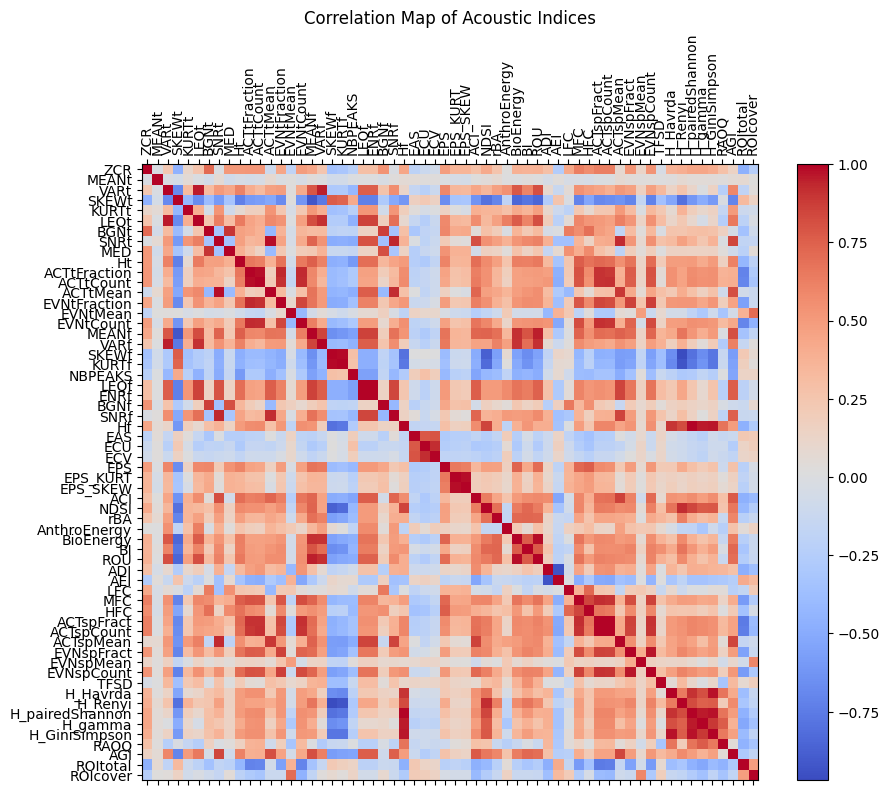

In [109]:
# Display results
import matplotlib.pyplot as plt

# Drop non-numeric columns (such as the file path)
df_indices_numeric = df_indices.select_dtypes(include=['number'])

# Plot a correlation map
fig, ax = plt.subplots(figsize=(10, 8))
df_indices_corr = df_indices_numeric.corr()  # Correlation matrix for numeric columns
cax = ax.matshow(df_indices_corr, cmap='coolwarm')
fig.colorbar(cax)
plt.xticks(range(len(df_indices_corr.columns)), df_indices_corr.columns, rotation=90)
plt.yticks(range(len(df_indices_corr.columns)), df_indices_corr.columns)
plt.title('Correlation Map of Acoustic Indices')
plt.show()

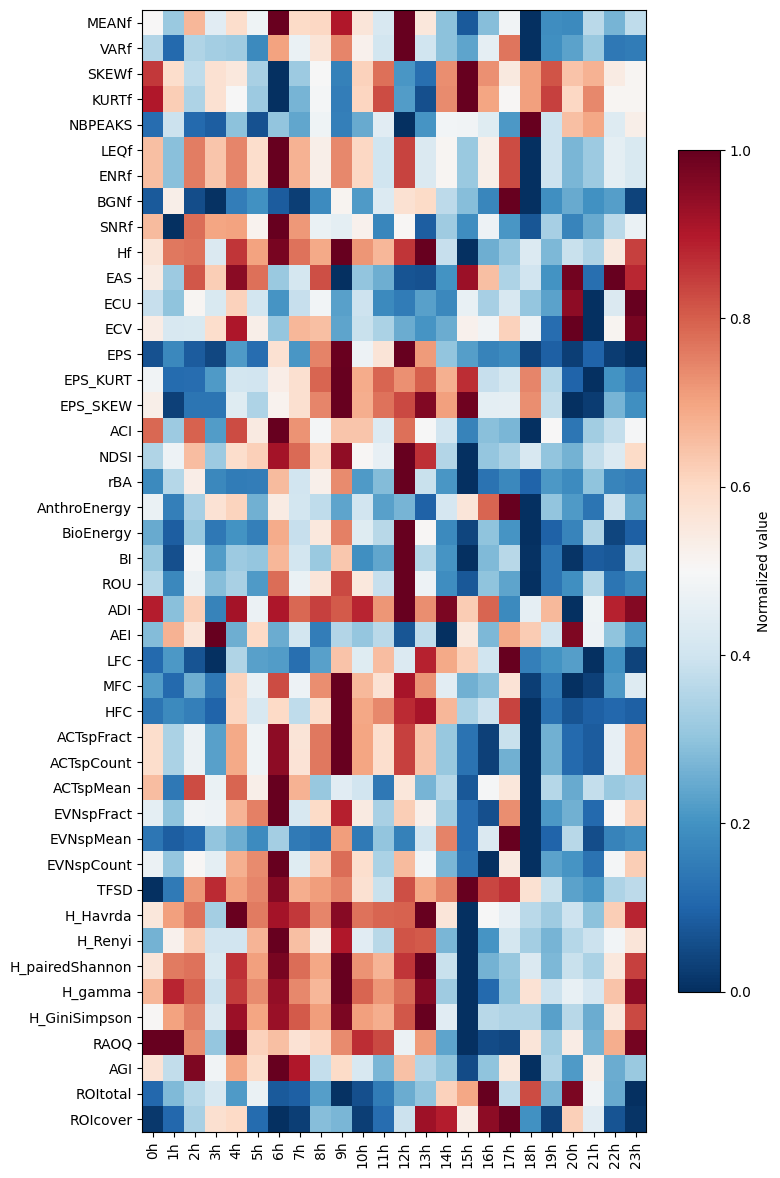

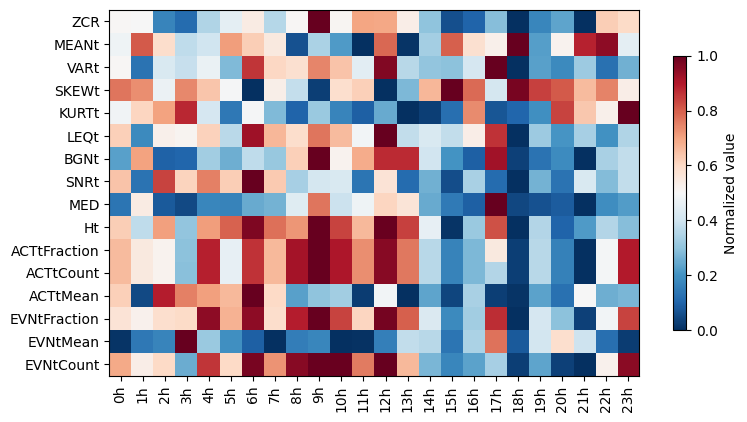

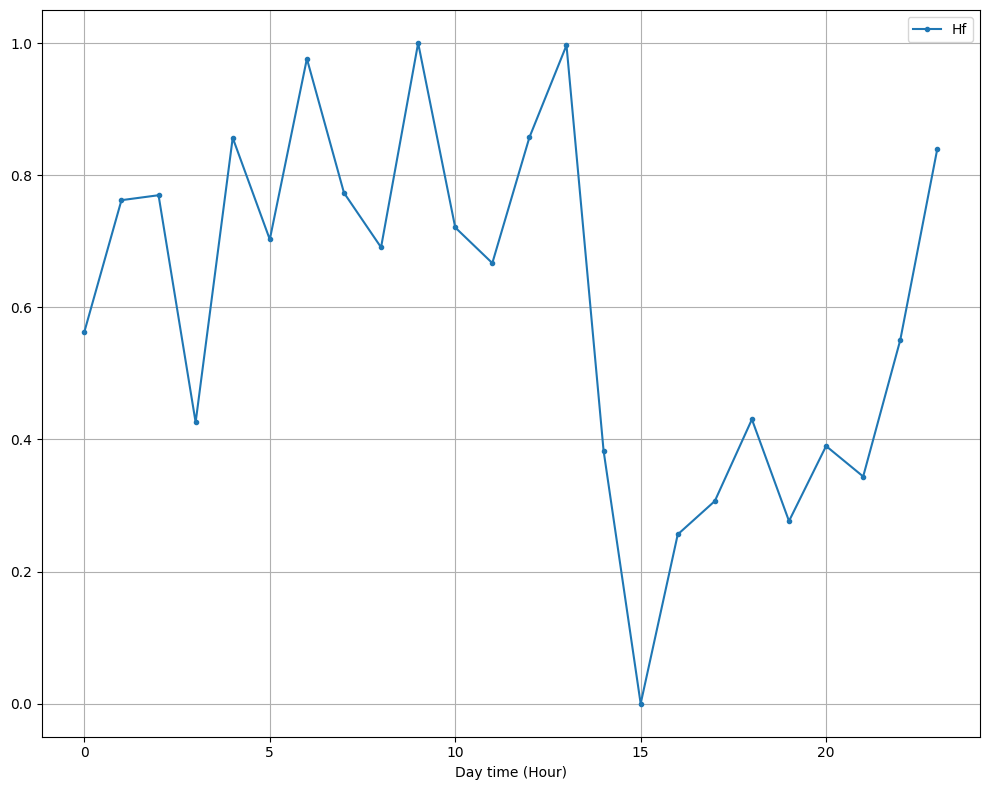

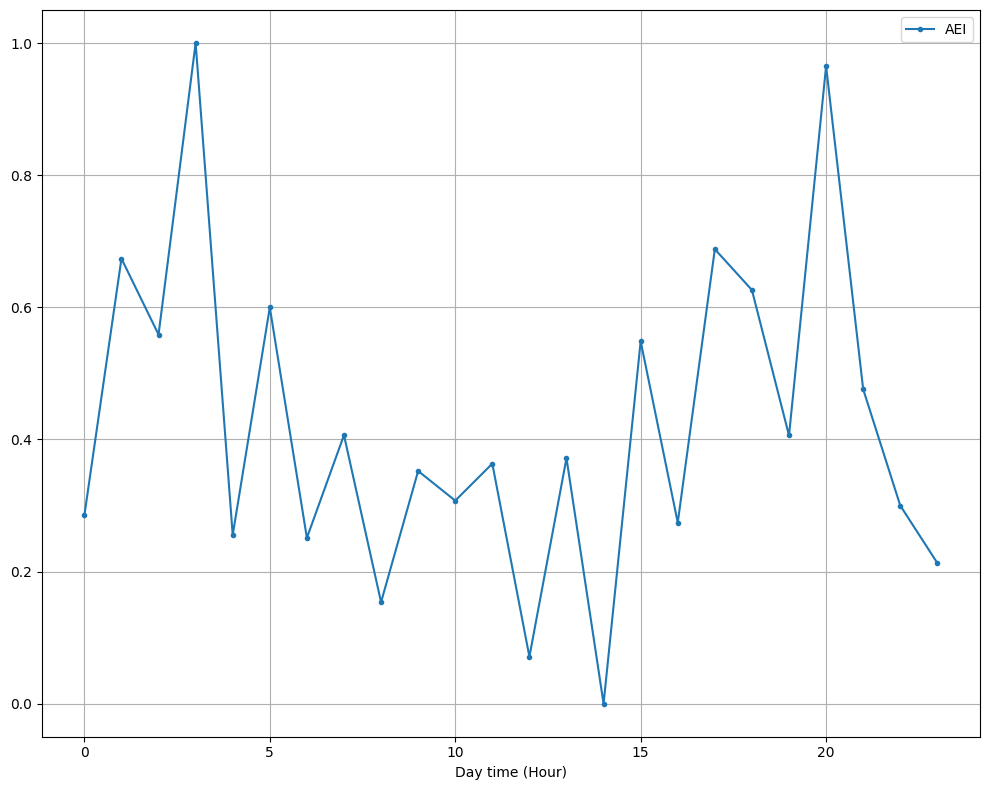

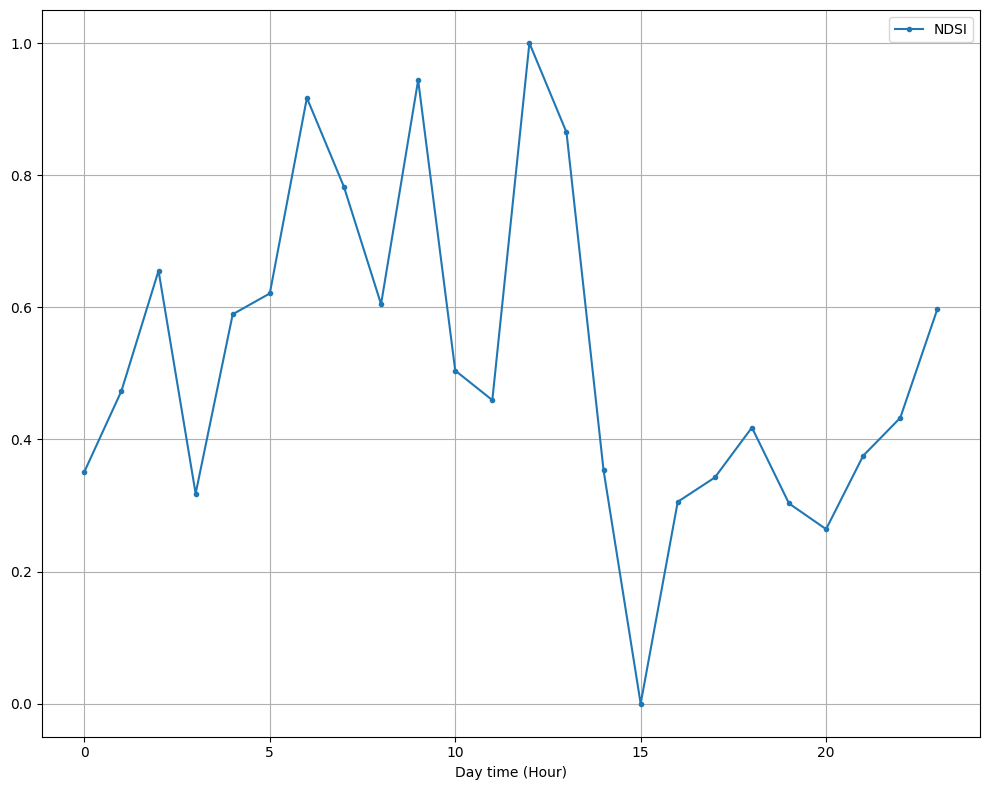

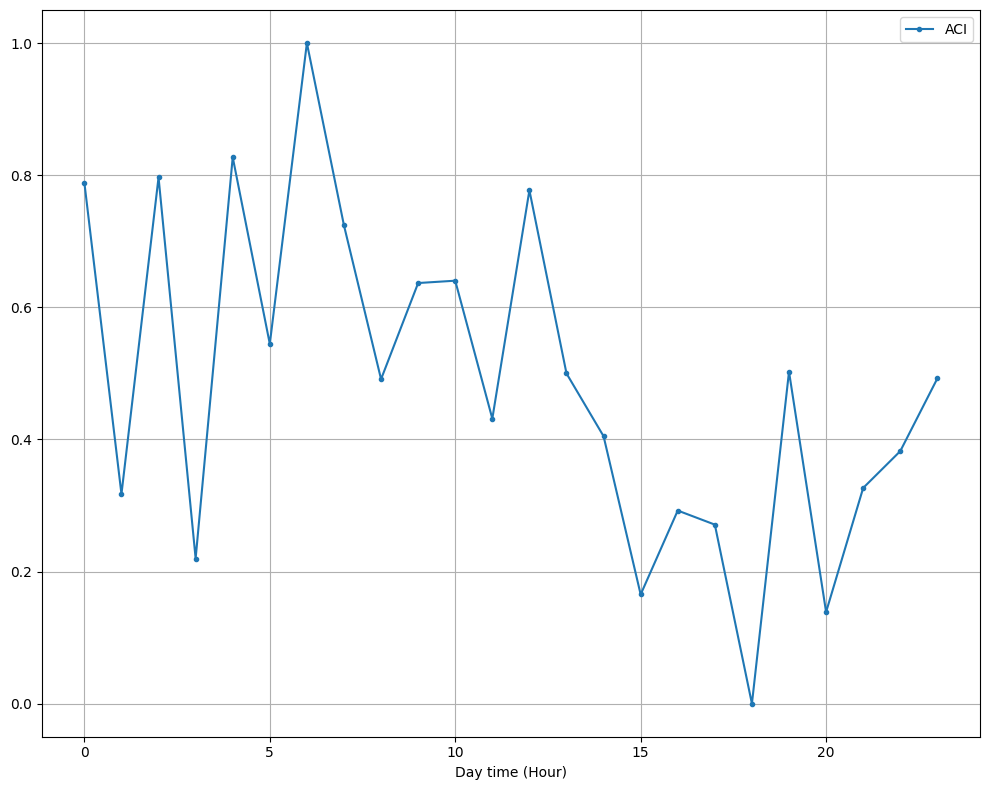

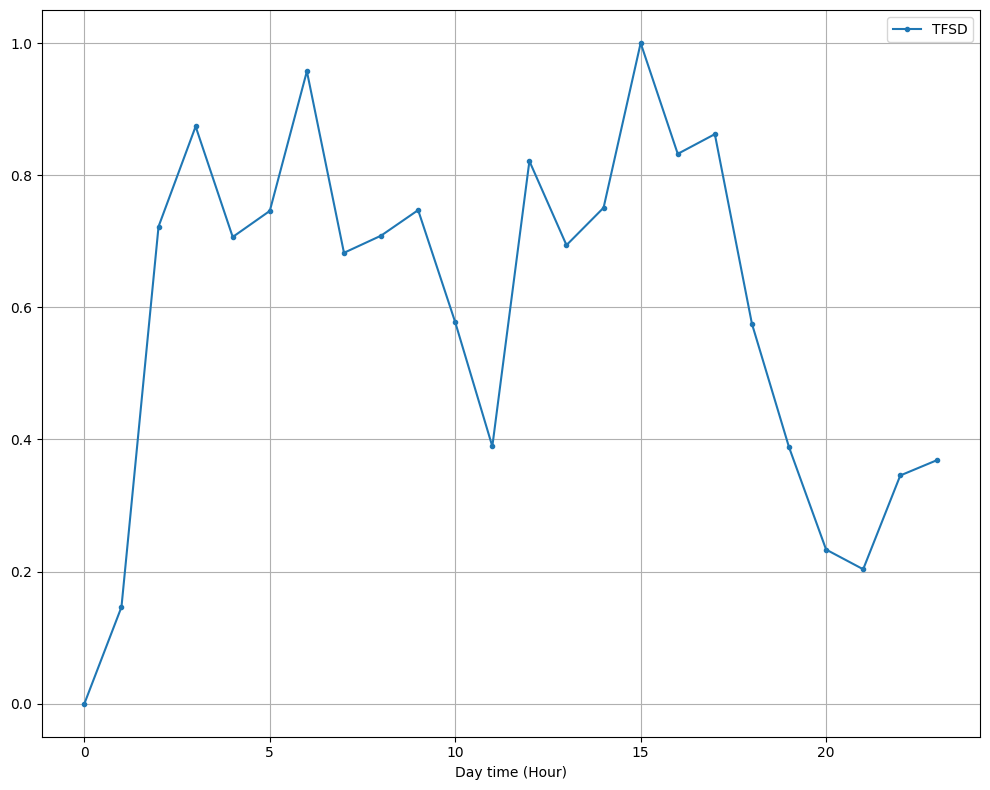

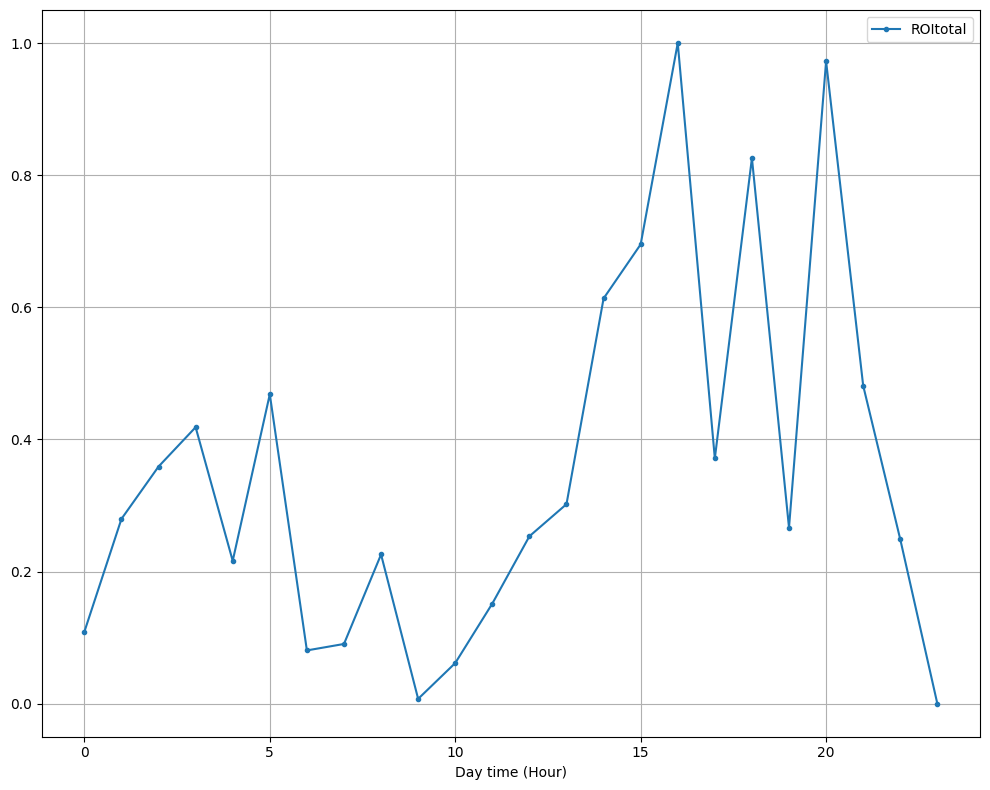

In [110]:
# Plot heatmaps of the indices
from maad.util import plot_features_map
plot_features_map(df_indices_numeric[SPECTRAL_FEATURES], mode='24h')
plot_features_map(df_indices_numeric[TEMPORAL_FEATURES], mode='24h')

# A more classical way to analyse variations of indices consists in plotting
# graphs. We choose to normalize rescale their value between 0 to 1 in order to
# compare their trend during a 24h cycle

# Plot each index individually
fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['Hf']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['AEI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['NDSI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['ACI']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['TFSD']], norm=True, mode='24h', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
plot_features(df_indices[['ROItotal']], norm=True, mode='24h', ax=ax)
plt.show()


In [111]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Filepath to your CSV
csv_filepath = "/Users/jillmunger/Desktop/UNH/coding/bvi_mangroves/acoustic_indices/acoustic_indices.csv"

# Read the CSV into a DataFrame
try:
    df_indices = pd.read_csv(csv_filepath)
except FileNotFoundError:
    print(f"Error: File not found at {csv_filepath}")
    exit()  # Stop execution if the file is not found

# Check if 'file' column exists
if 'file' not in df_indices.columns:
    print("Error: 'file' column not found in the CSV.")
    print("Columns in the CSV:", df_indices.columns)
    exit()

# Function to extract the site number from the filename
def extract_site_number(file):
    """Extracts the 4-digit site number from the filename."""
    filename = file.split('/')[-1]  # Get the filename after the last /
    match = re.search(r'BVI_mangroves_(\d{4})_', filename)  # Look for BVI_mangroves_4digits_
    if match:
        return int(match.group(1))
    else:
        return None

def extract_date(file):
    """Extracts the date (YYYYMMDD) from the filename."""
    match = re.search(r'_(\d{8})_', file)
    if match:
        date_str = match.group(1)
        return pd.to_datetime(date_str, format='%Y%m%d')
    else:
        return None

def extract_time_str(file):
    """Extracts the time (HHMMSS) as a string from the filename."""
    match = re.search(r'_(\d{6})\.wav$', file)  # Look for _HHMMSS.wav at the end
    if match:
        return match.group(1)  # Return the time string (HHMMSS)
    else:
        return None

def extract_hour_from_time_string(time_str):
    """Extracts the hour from a HHMMSS time string."""
    if time_str:
        return int(time_str[:2])  # Extract the first two characters (hour)
    else:
        return None

# Dictionary mapping site numbers to site names
site_mapping = {
    6863: 'paraquita',
    6879: 'french',
    6880: 'hans',
    6864: 'scb'
}

# Apply extraction to df_indices
df_indices['Site'] = df_indices['file'].apply(lambda x: site_mapping.get(extract_site_number(x), 'Unknown'))
df_indices['Date'] = df_indices['file'].apply(extract_date)
df_indices['Time'] = df_indices['file'].apply(extract_time_str)
df_indices['Hour'] = df_indices['Time'].apply(extract_hour_from_time_string)

# Group by hour and calculate the mean of 'Hf' for each hour
hourly_means = df_indices.groupby('Hour')['Hf'].mean()

# Now you can filter the dataframe by site
for site_num, site_name in site_mapping.items():
    site_data = df_indices[df_indices['Site'] == site_name]
    print(f"Data for {site_name}:")
    print(site_data.head())

# Get the list of index columns (starting from the second column)
index_columns = df_indices.columns[1:].tolist()

Data for paraquita:
                                                file          ZCR  \
0  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  2001.080245   
1  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  2204.862346   
2  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  5635.192766   
3  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  3416.594807   
4  /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mang...  5303.542016   

          MEANt      VARt      SKEWt        KURTt       LEQt       BGNt  \
0 -5.034445e-18  0.000015  32.514821  1823.001200  86.872135 -70.567953   
1 -4.747594e-18  0.000015  34.746623  1855.035316  86.650314 -71.040402   
2 -4.181866e-18  0.000010  31.377477  1135.859822  84.985590 -59.523447   
3 -1.920229e-18  0.000010  33.537236  1430.359492  85.021629 -63.008997   
4 -7.546395e-19  0.000010  33.343095  1370.362155  84.953355 -62.590220   

        SNRt       MED        Ht  ACTtFraction  ACTtCount   ACTtMean  \
0  27.556946  0.000296  0.351716      0.33

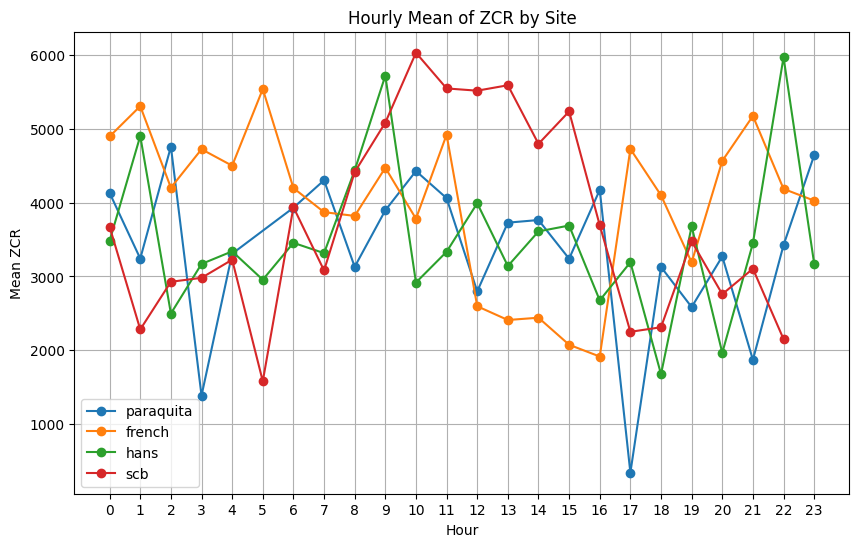

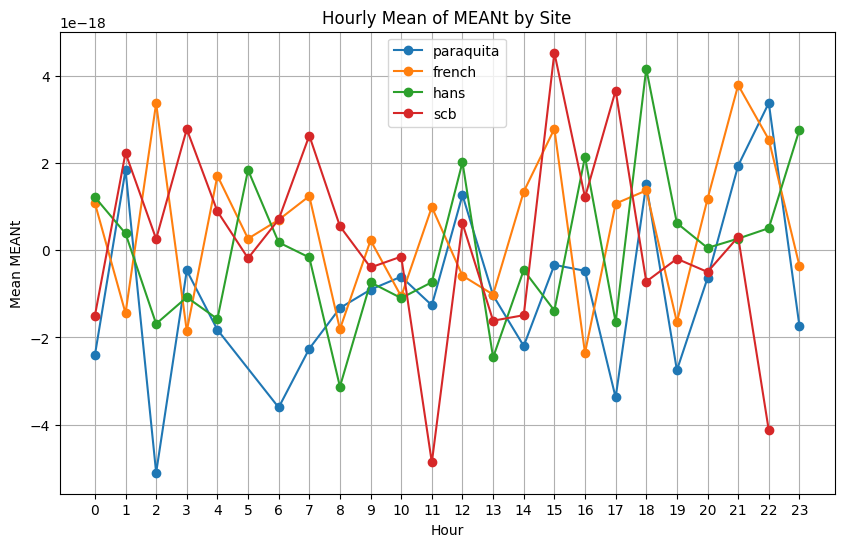

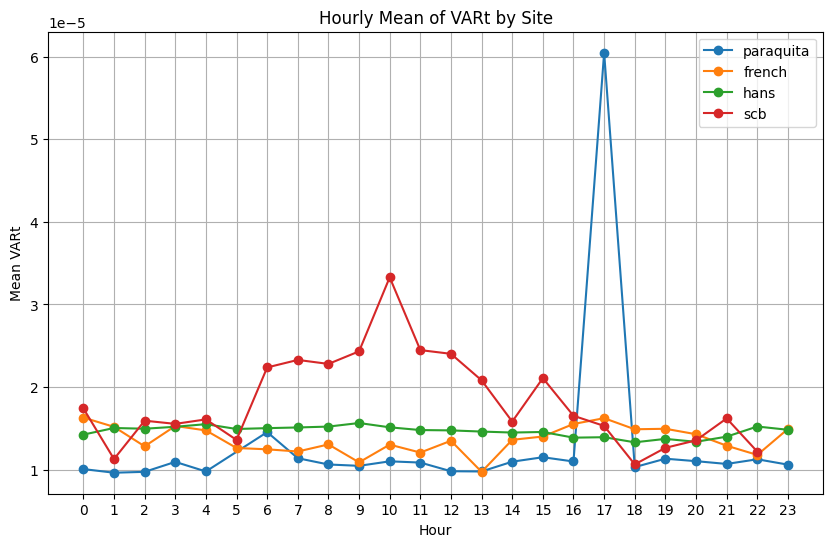

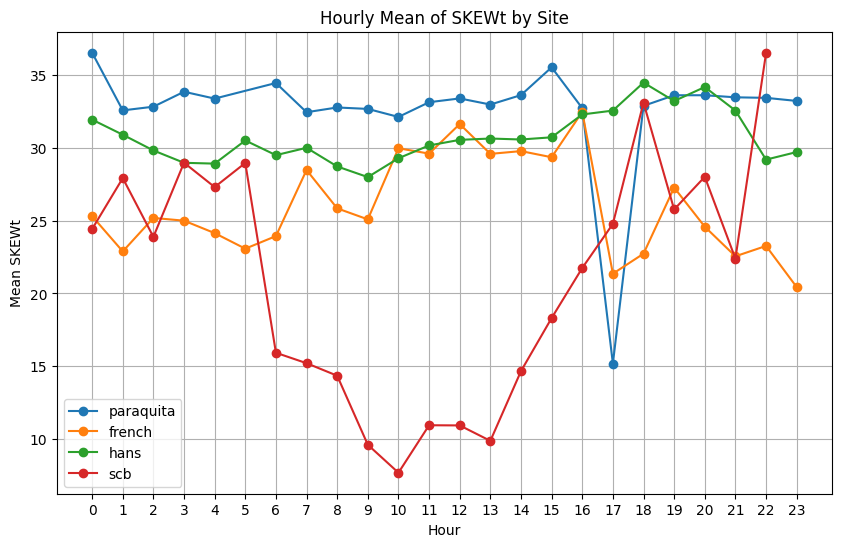

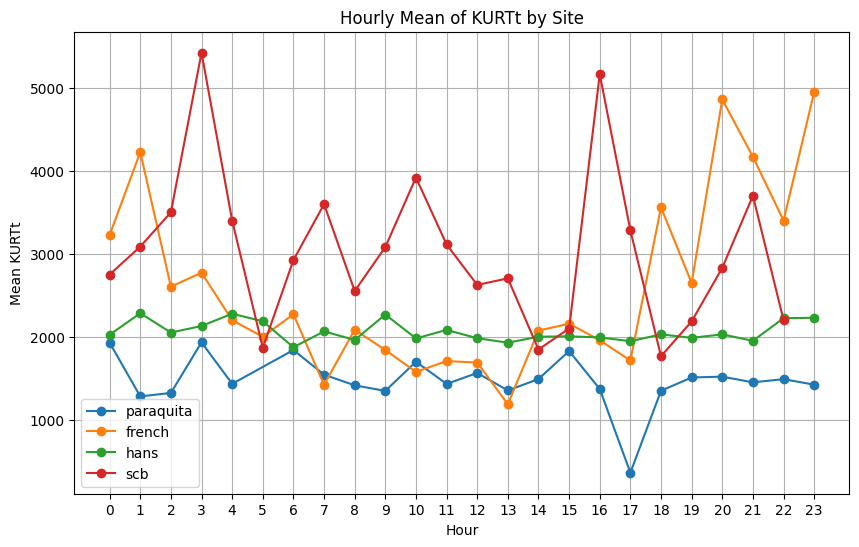

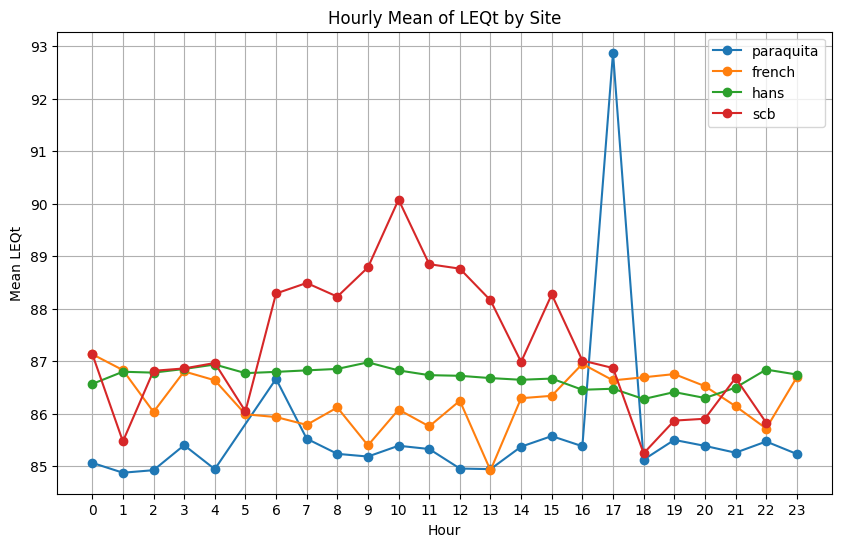

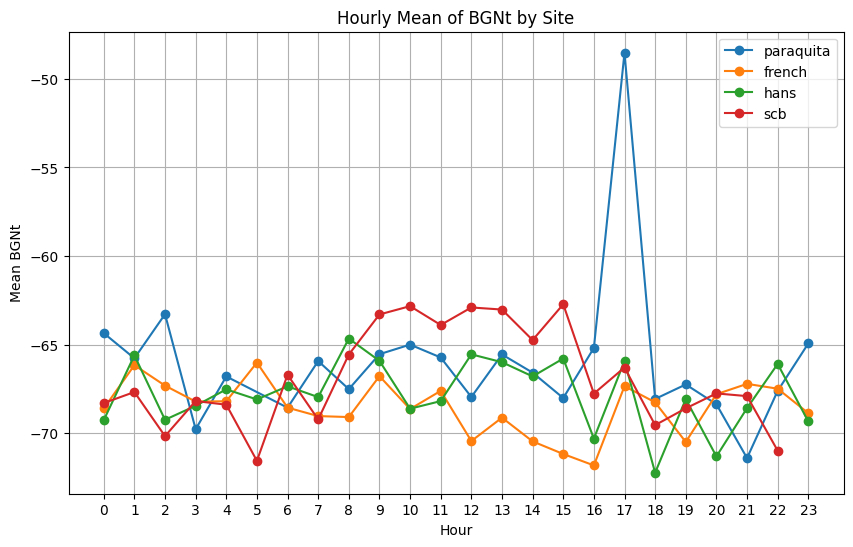

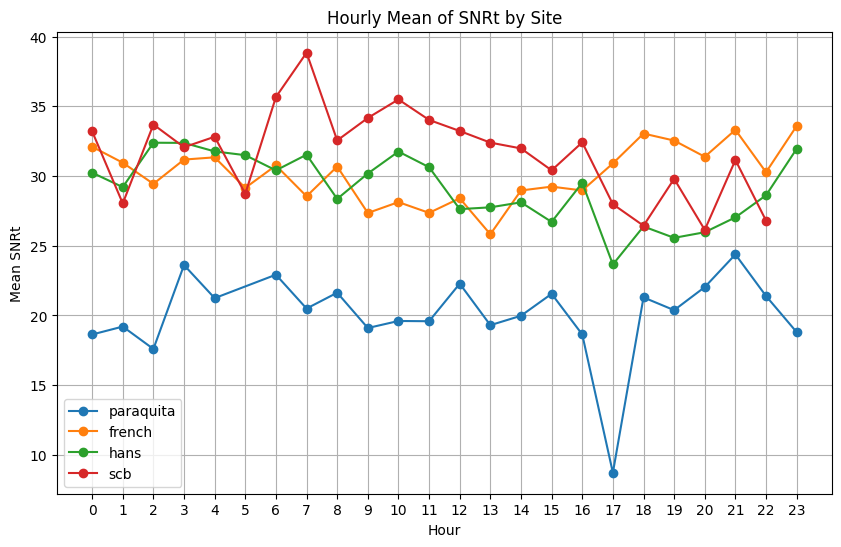

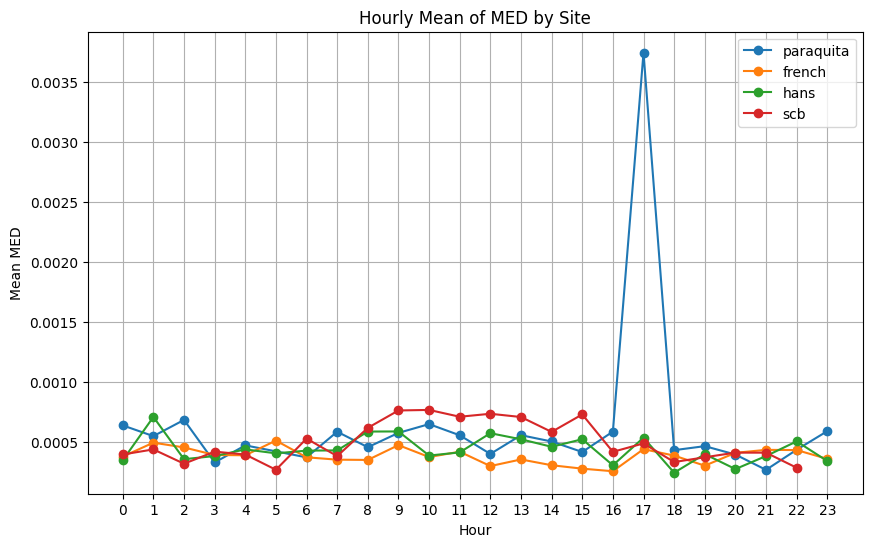

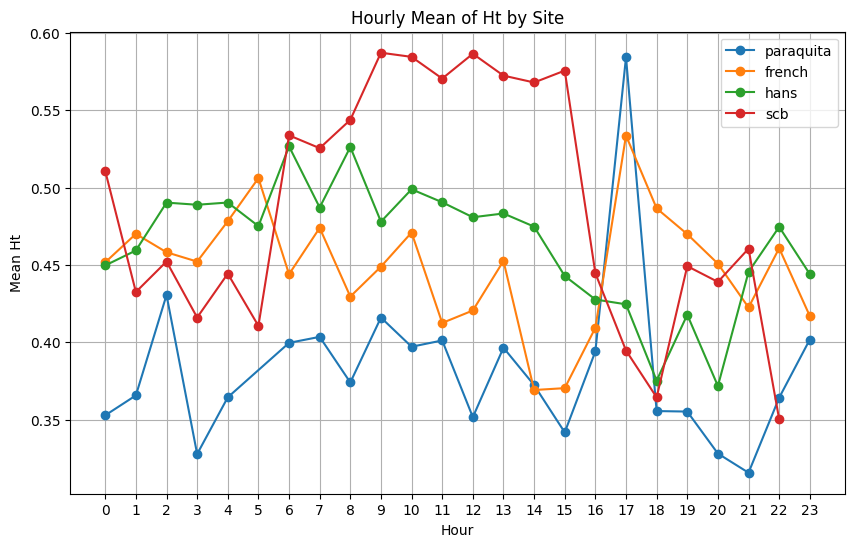

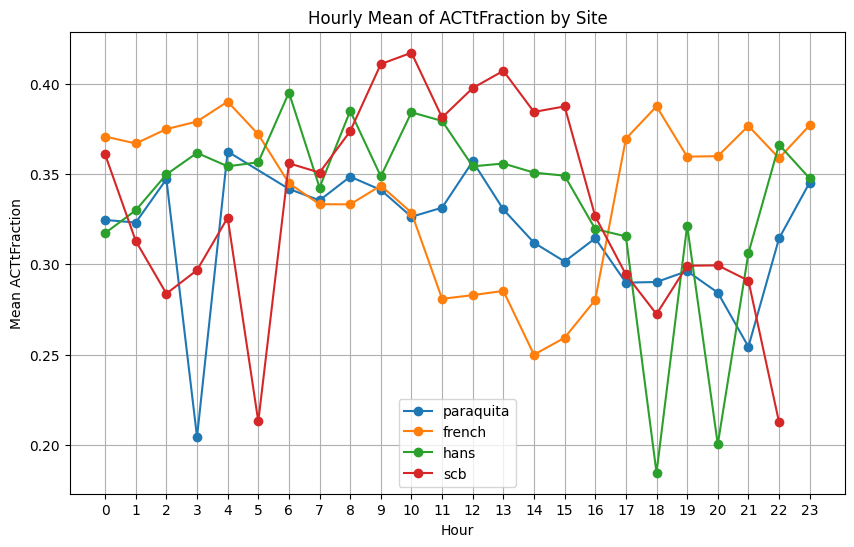

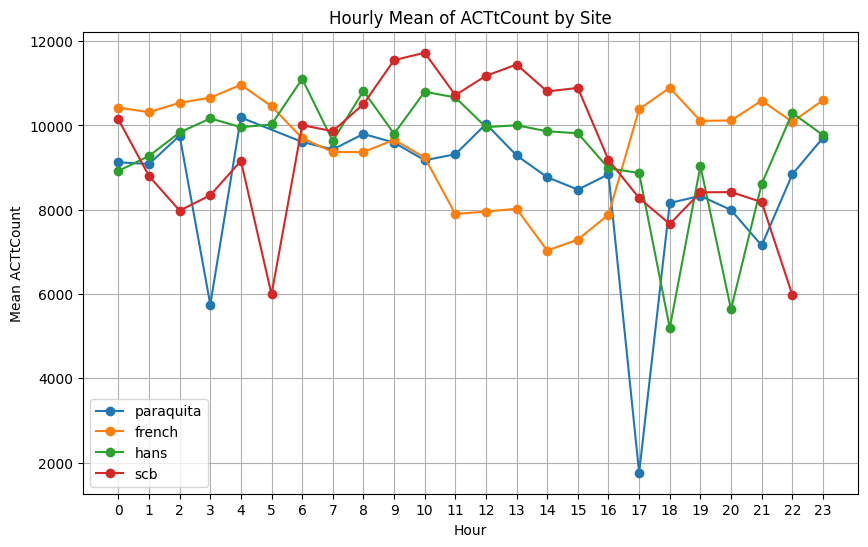

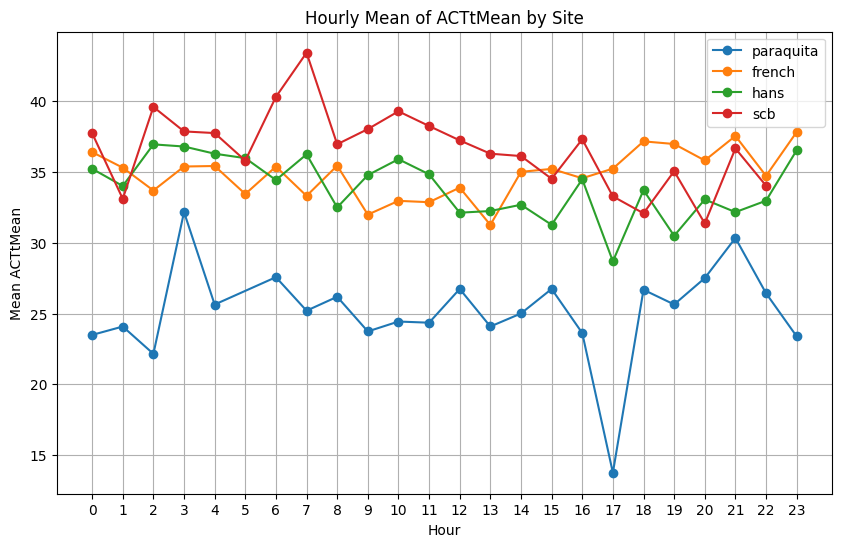

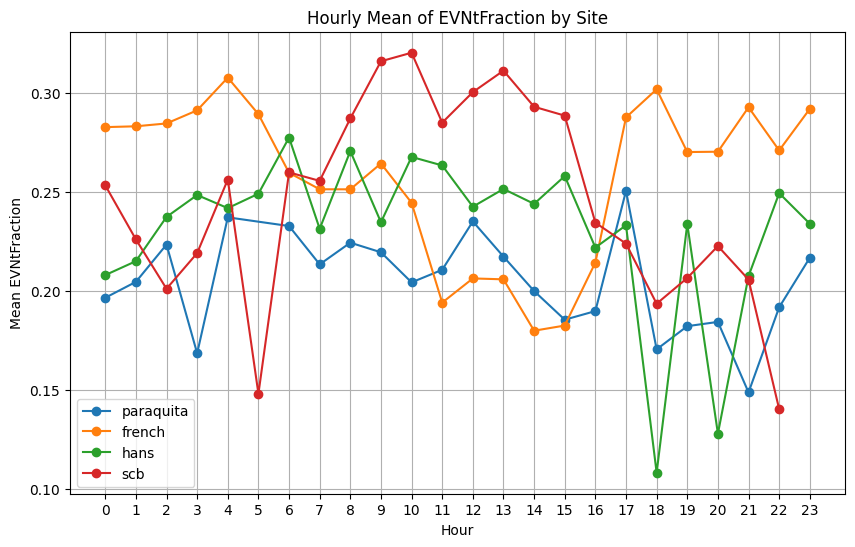

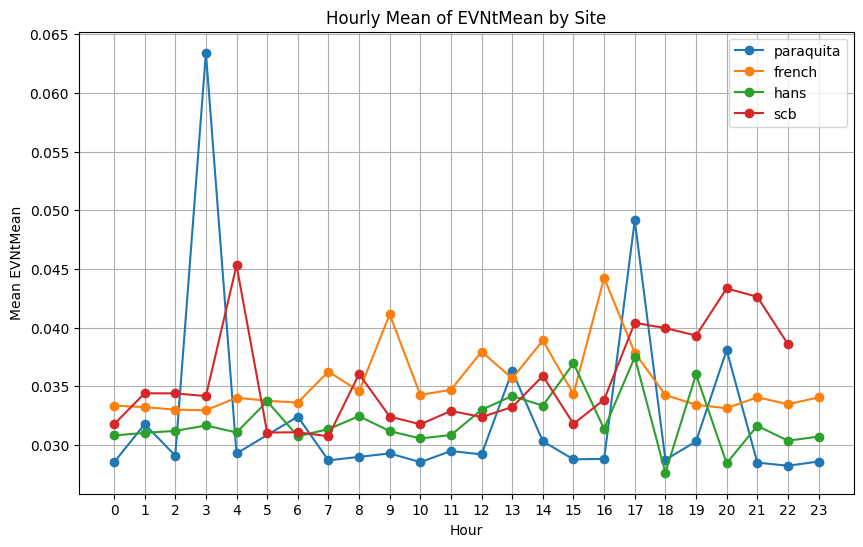

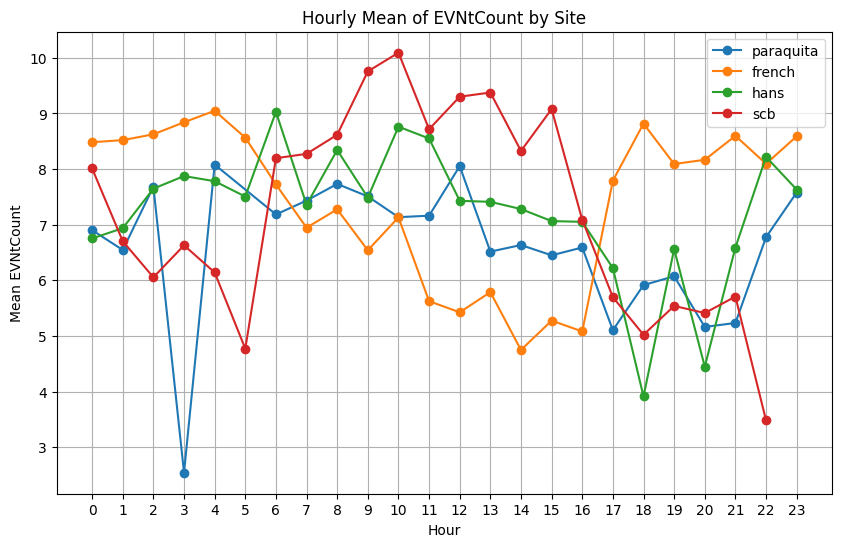

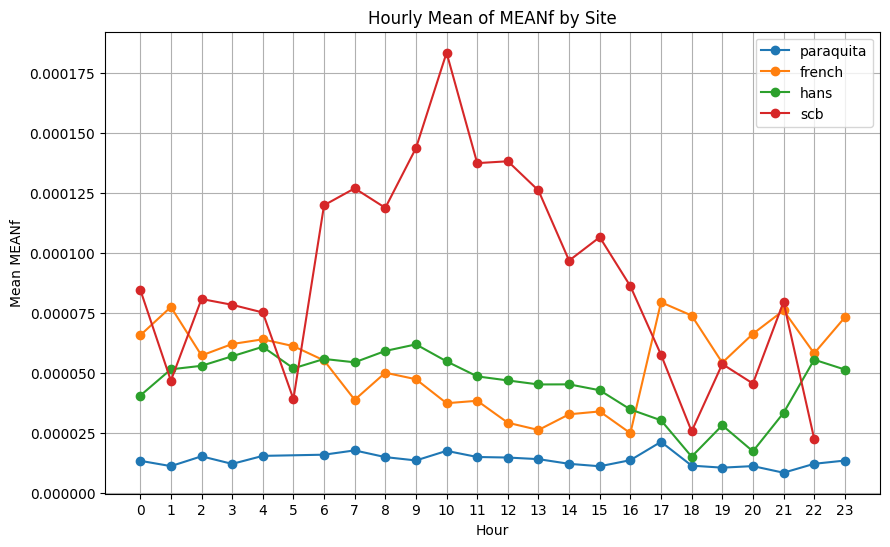

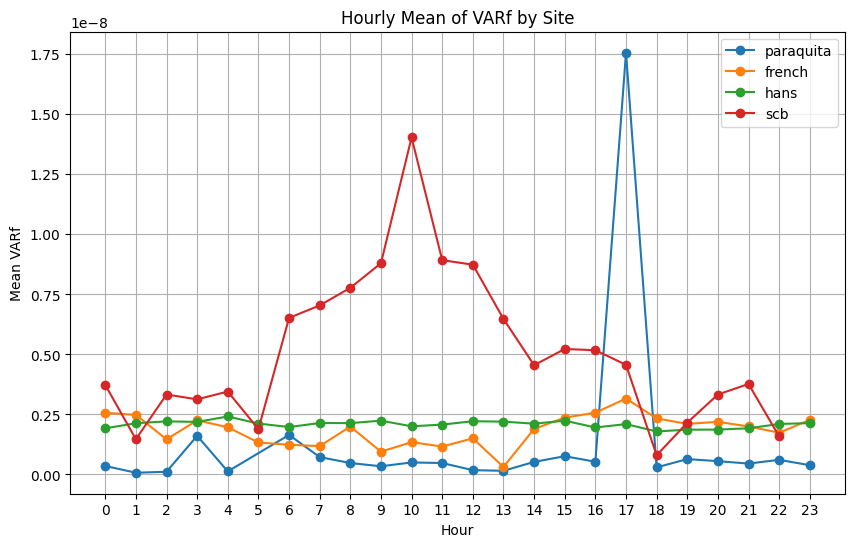

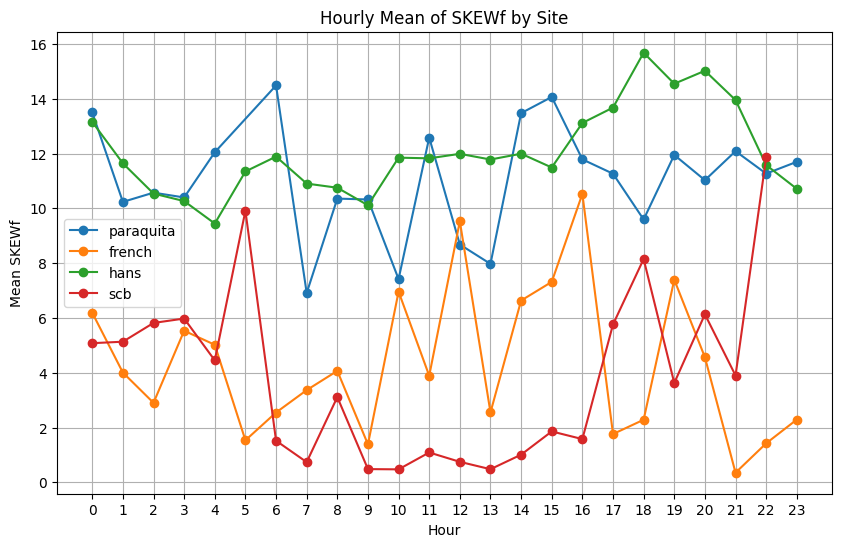

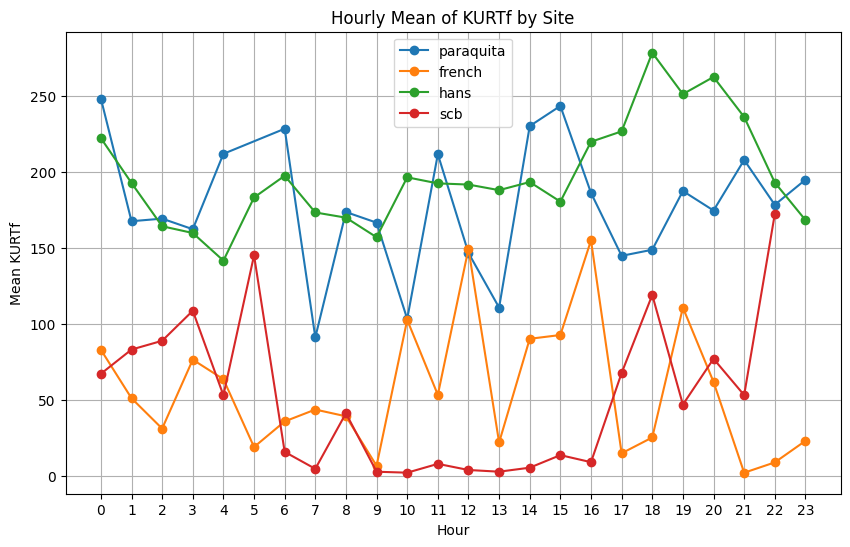

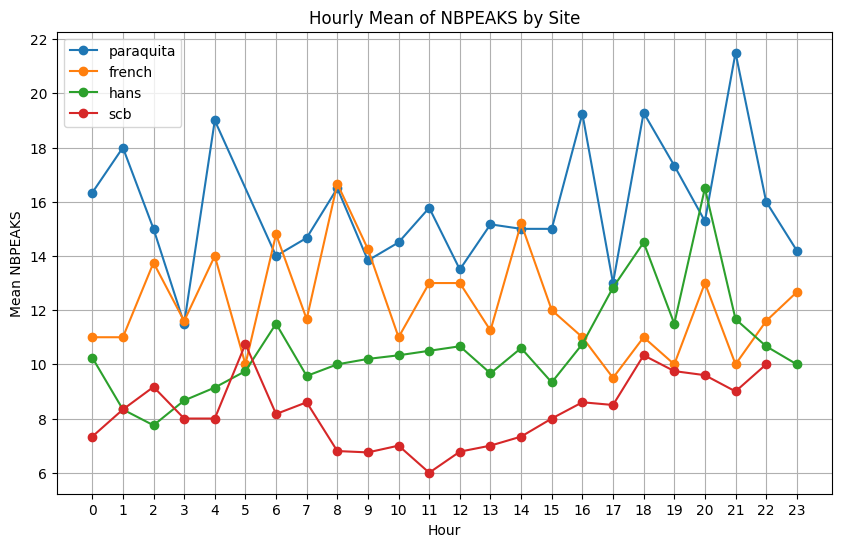

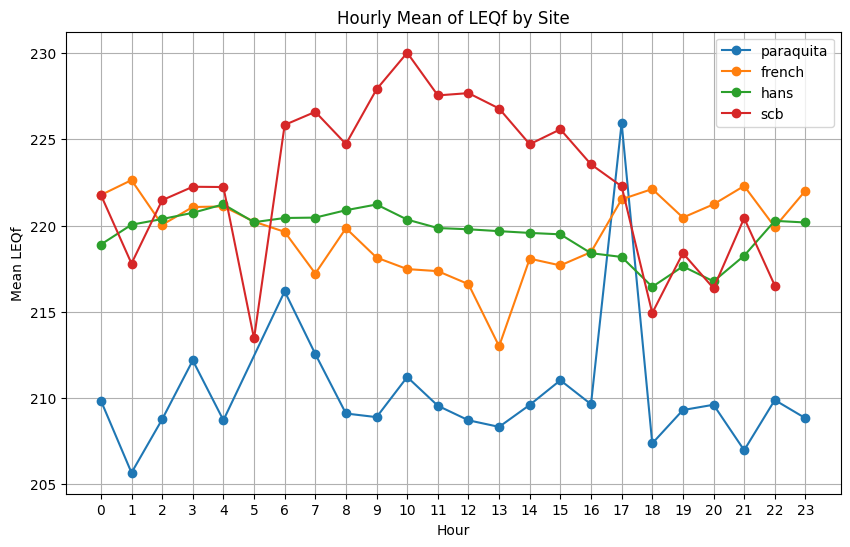

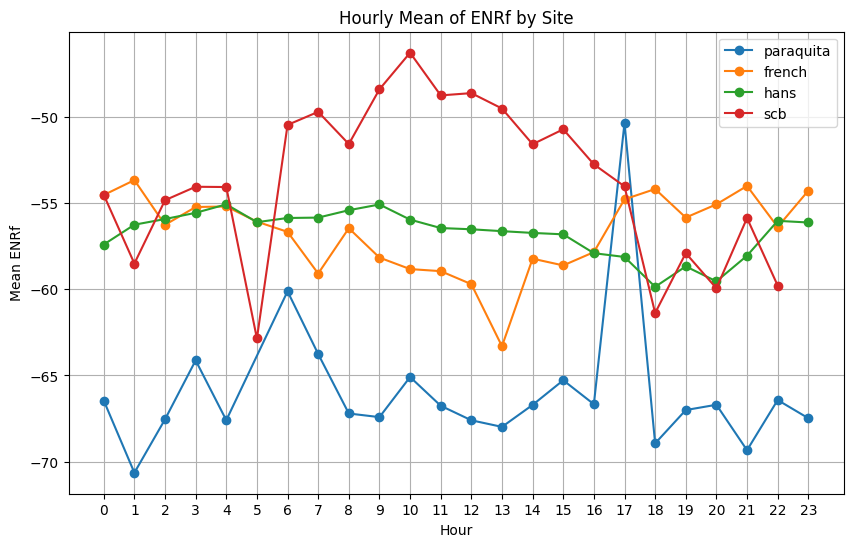

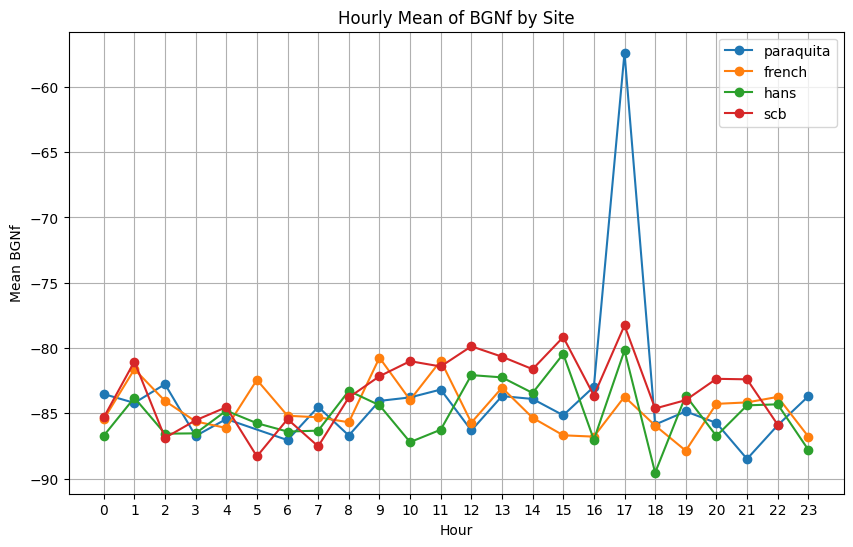

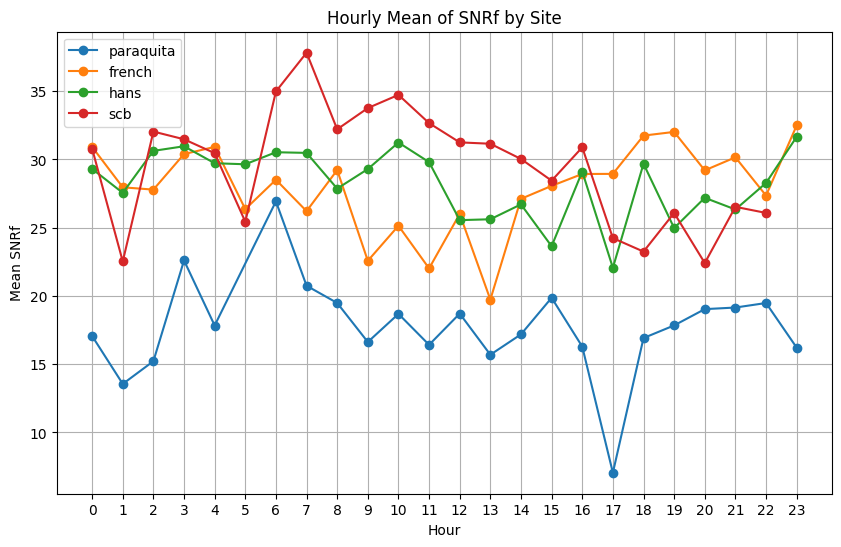

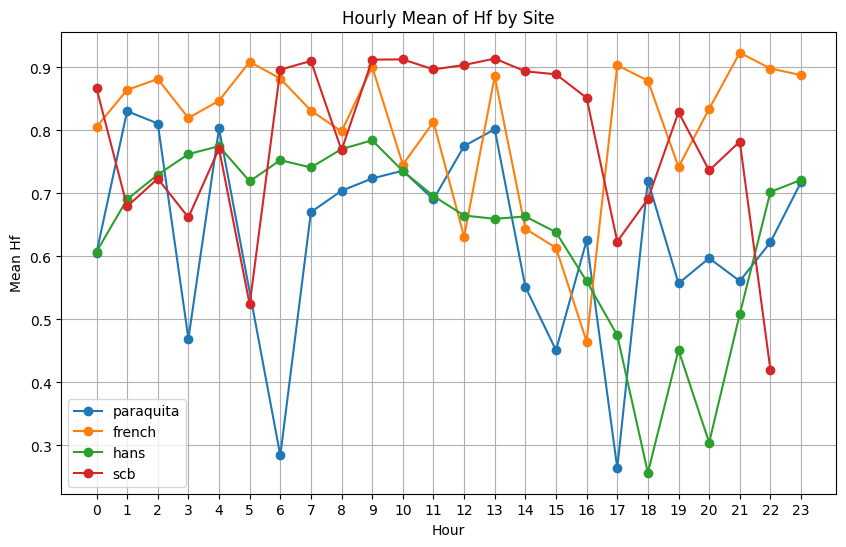

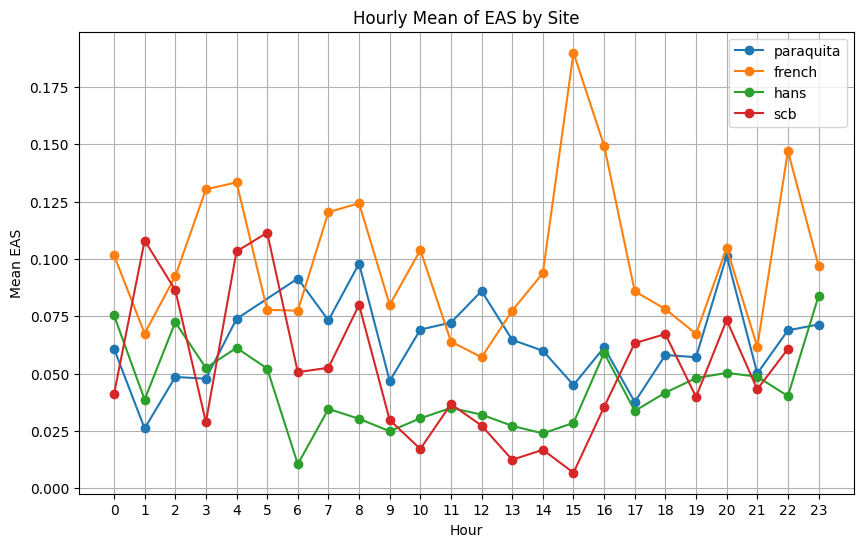

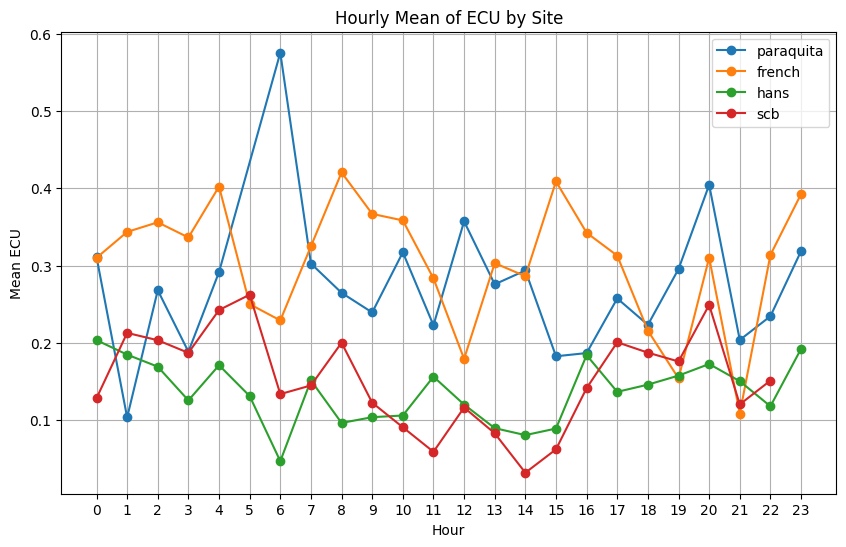

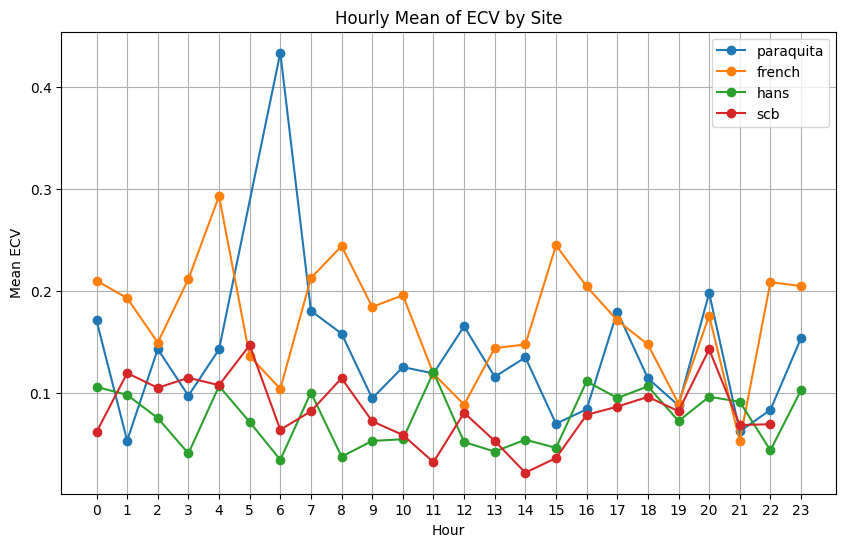

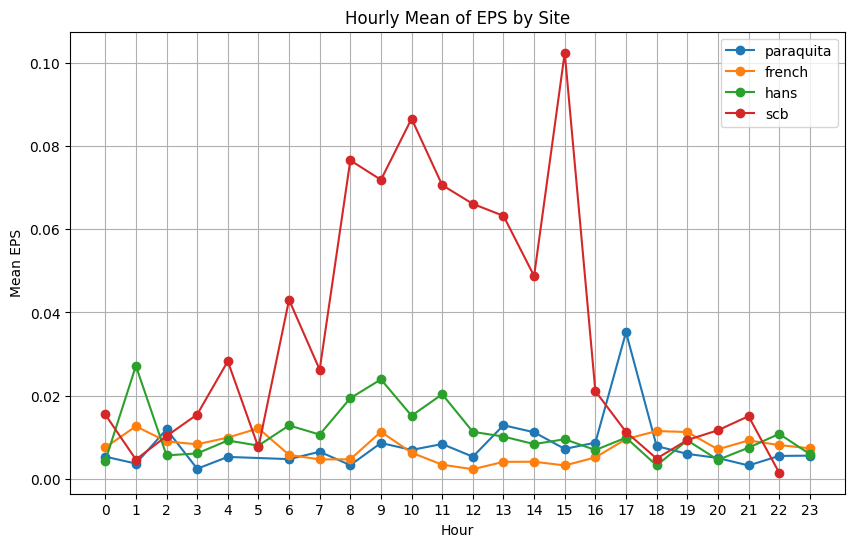

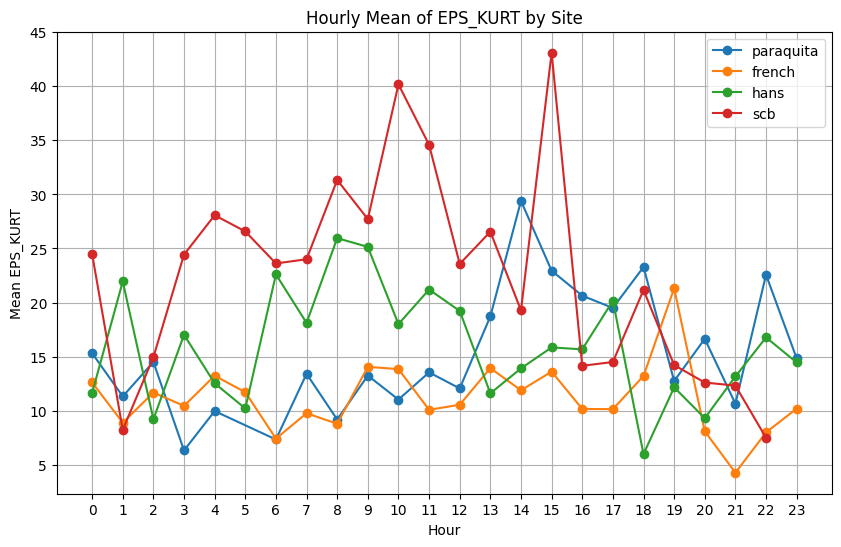

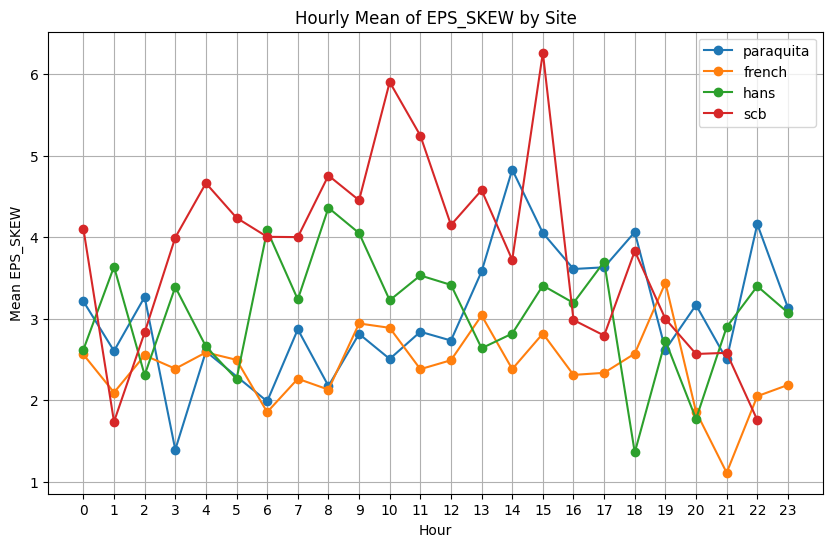

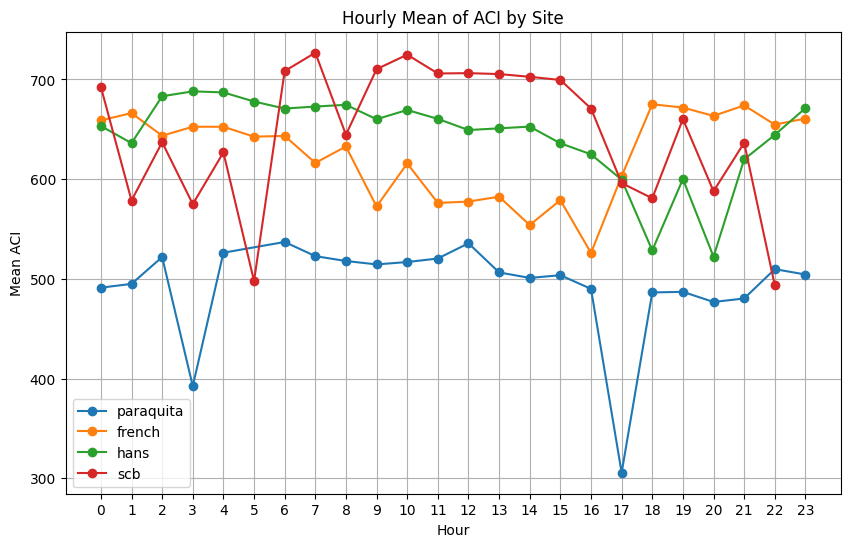

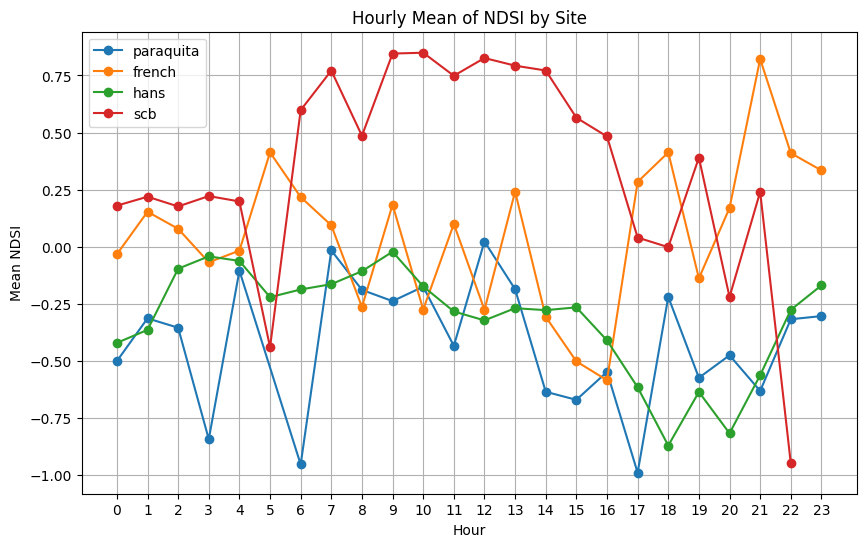

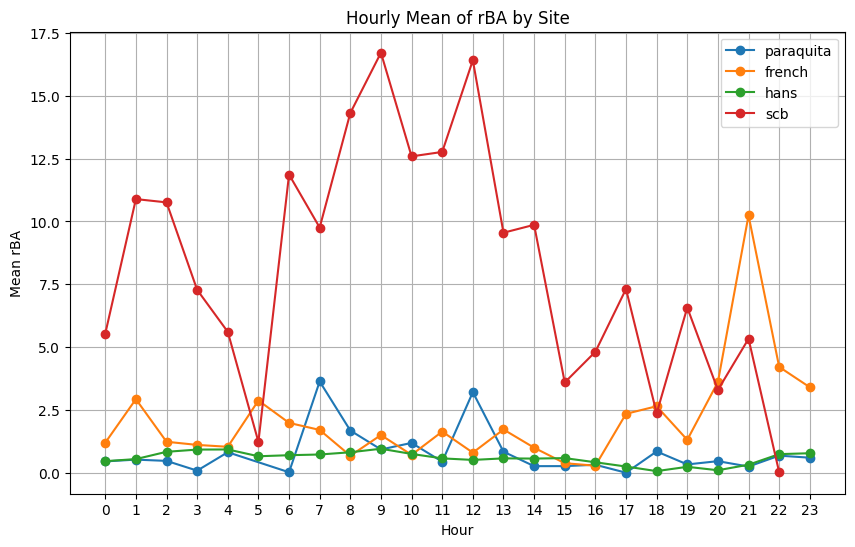

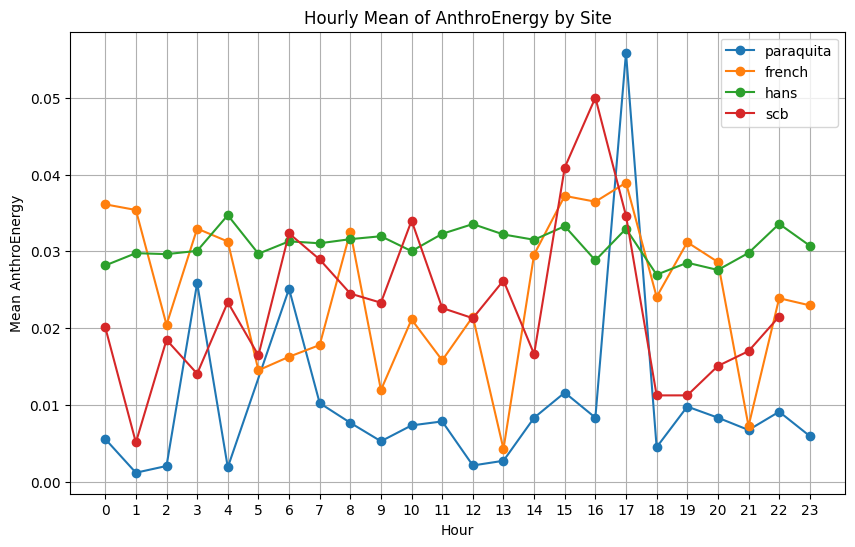

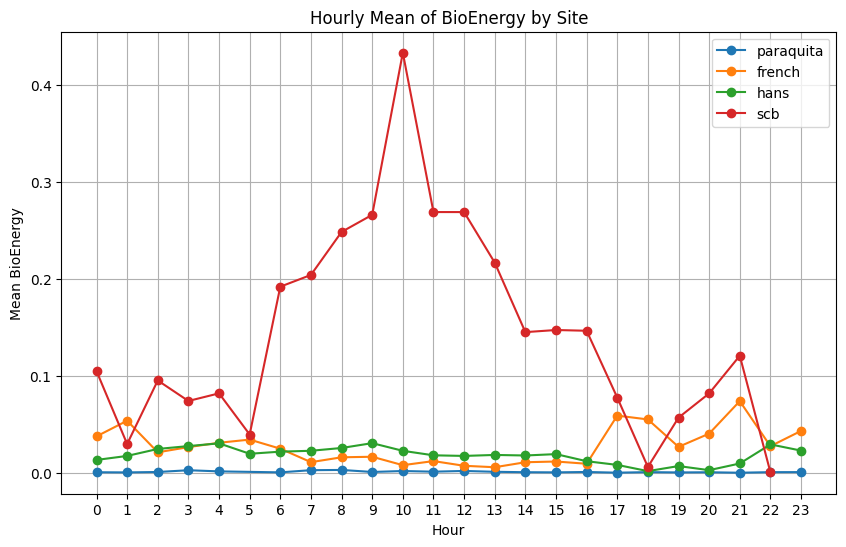

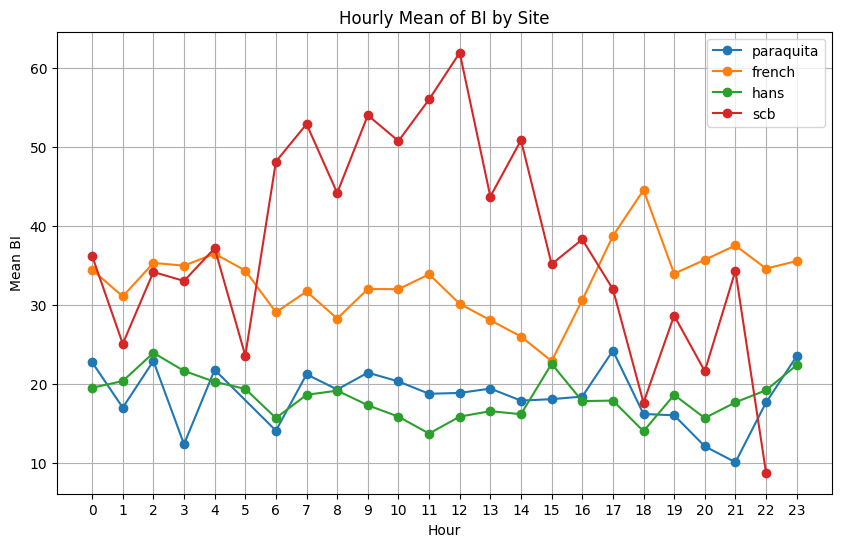

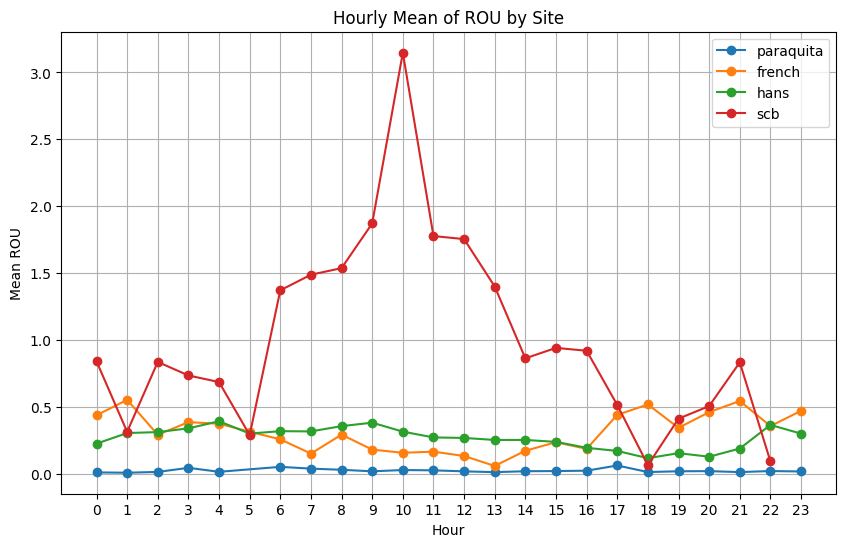

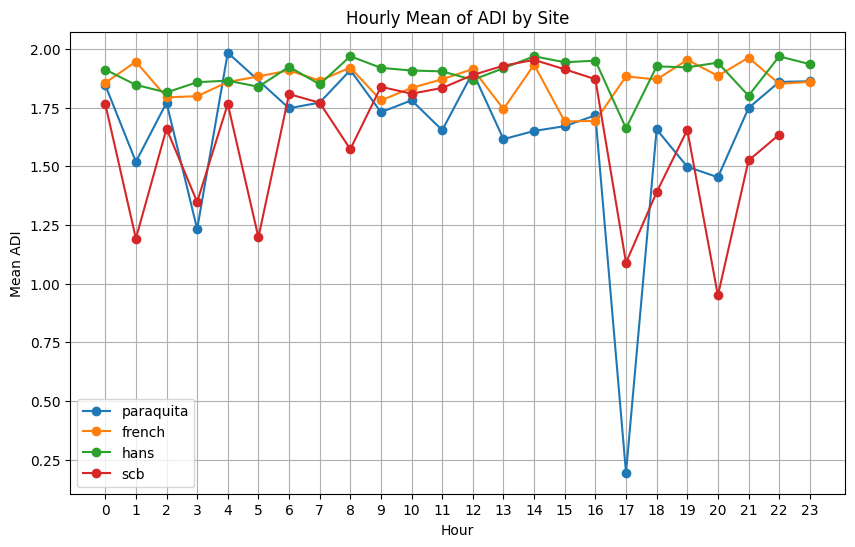

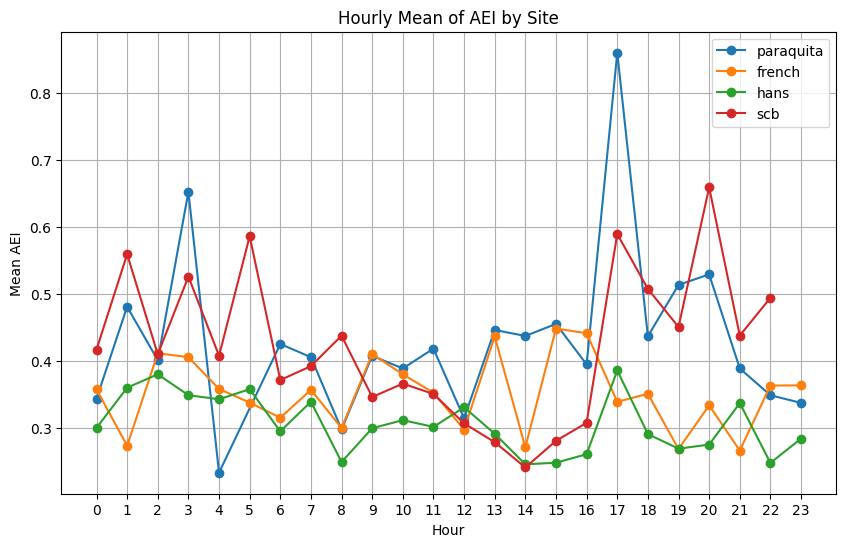

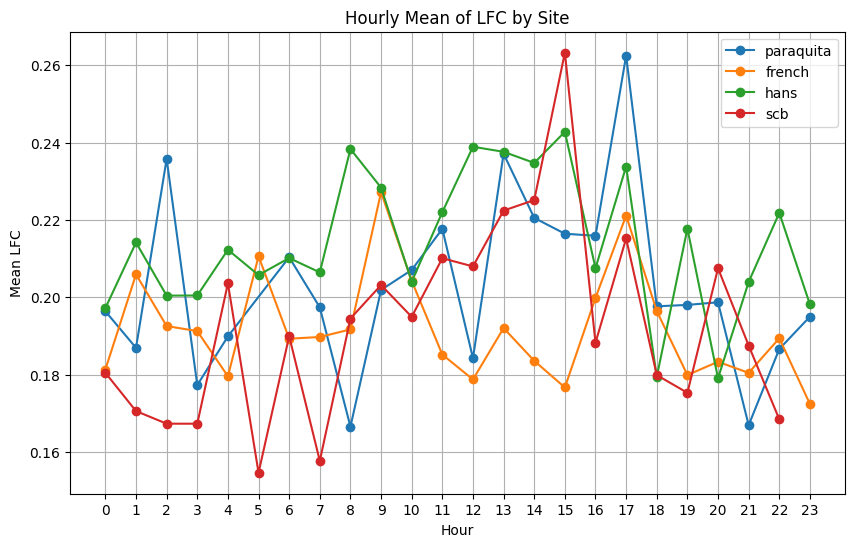

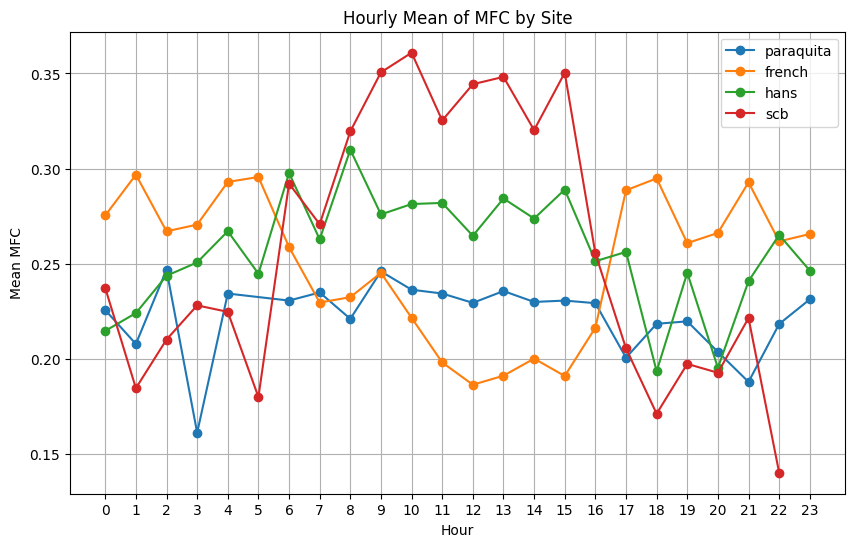

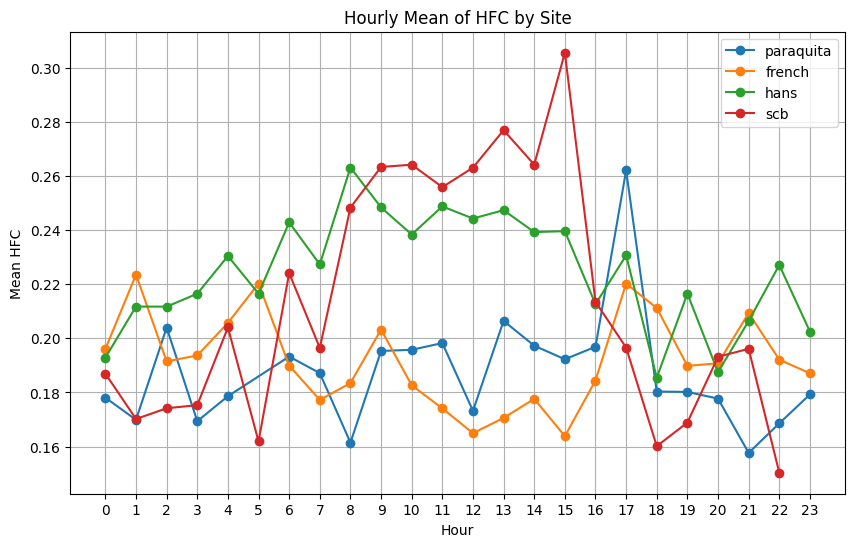

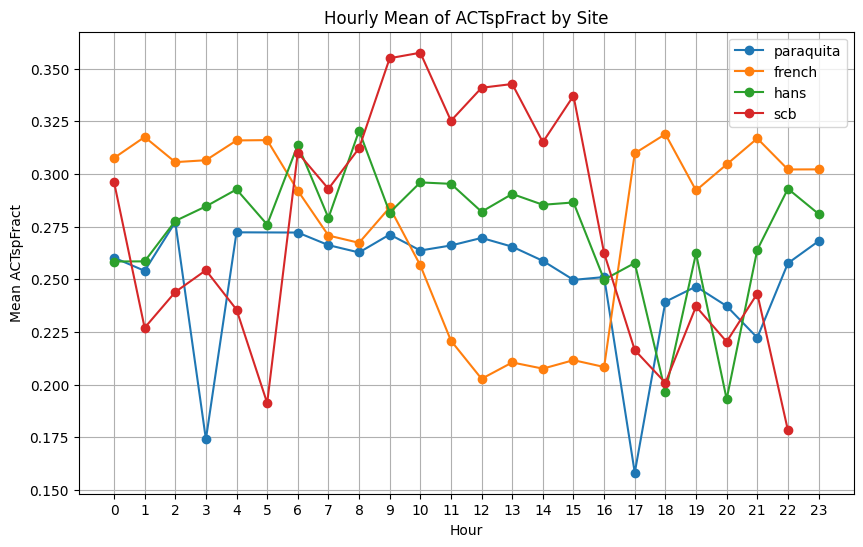

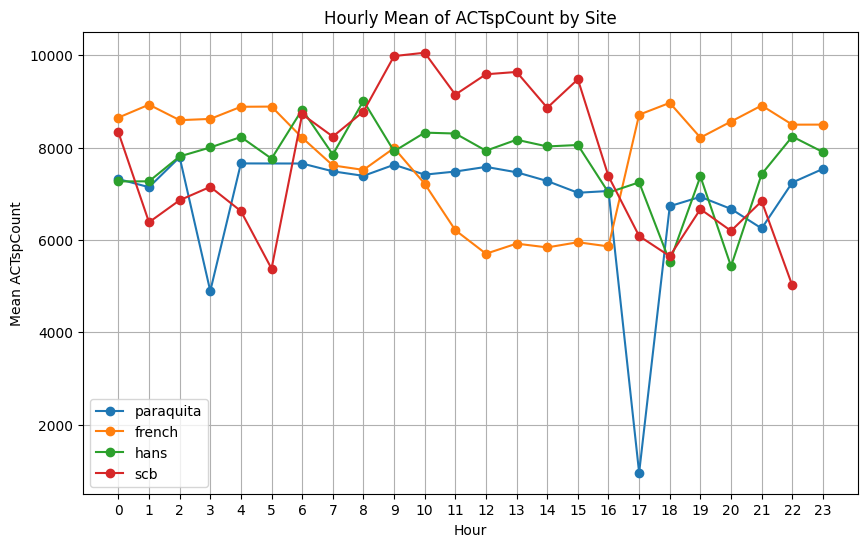

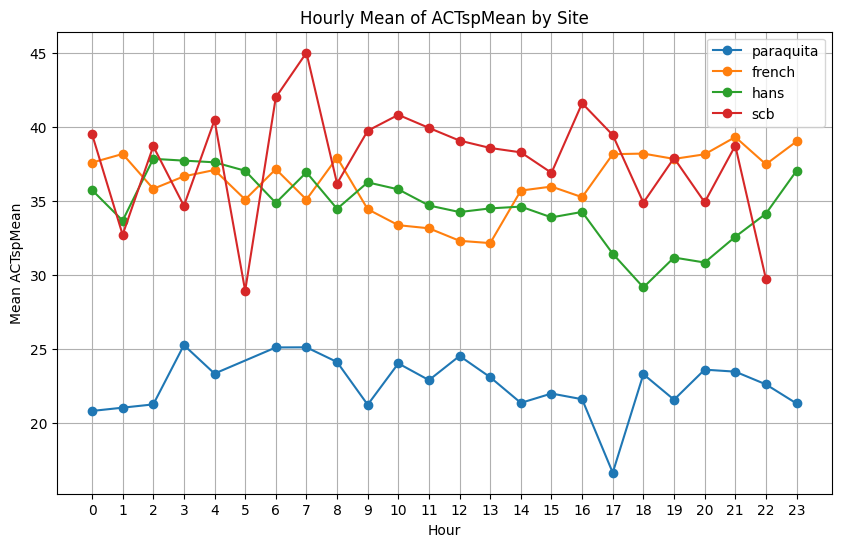

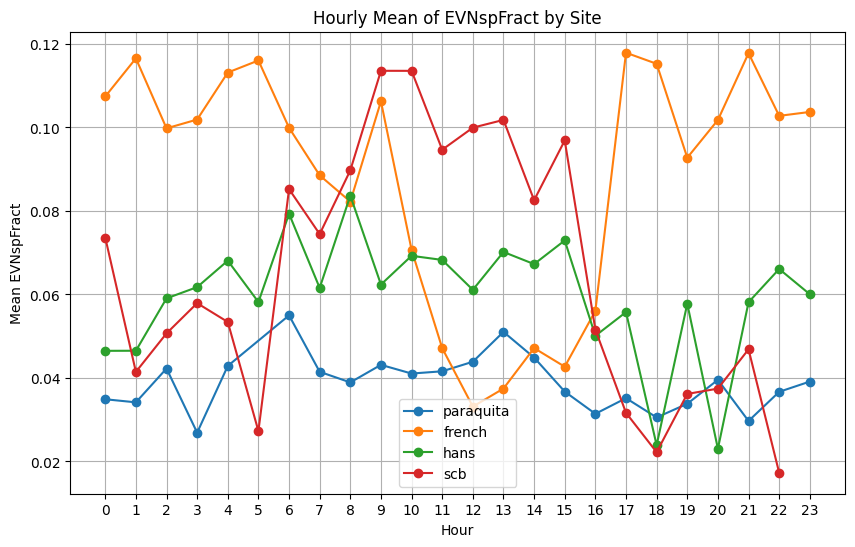

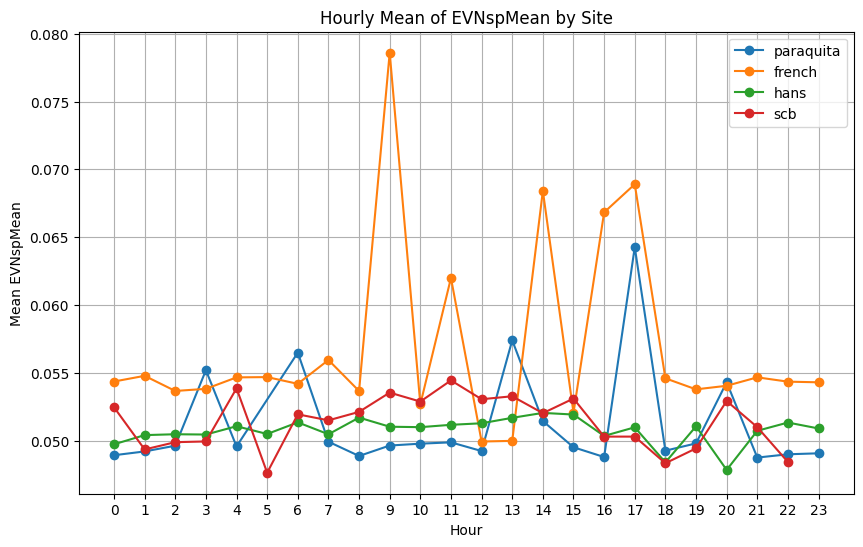

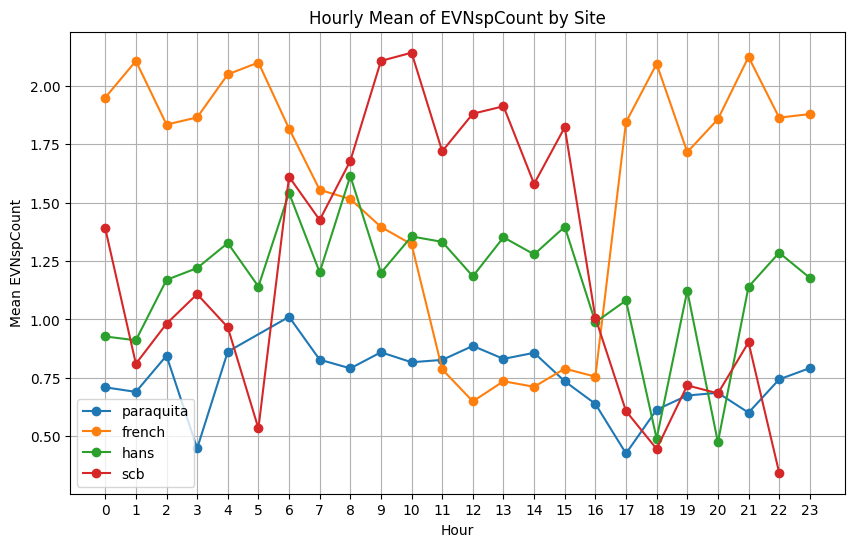

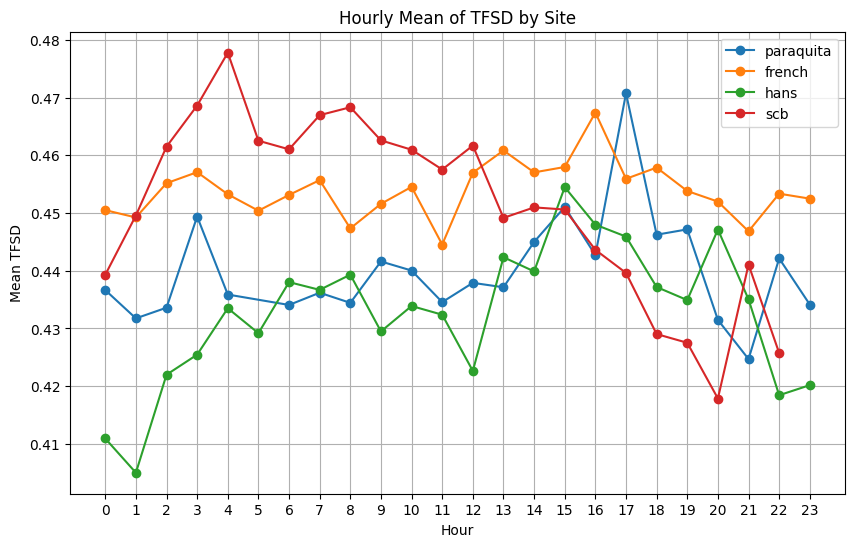

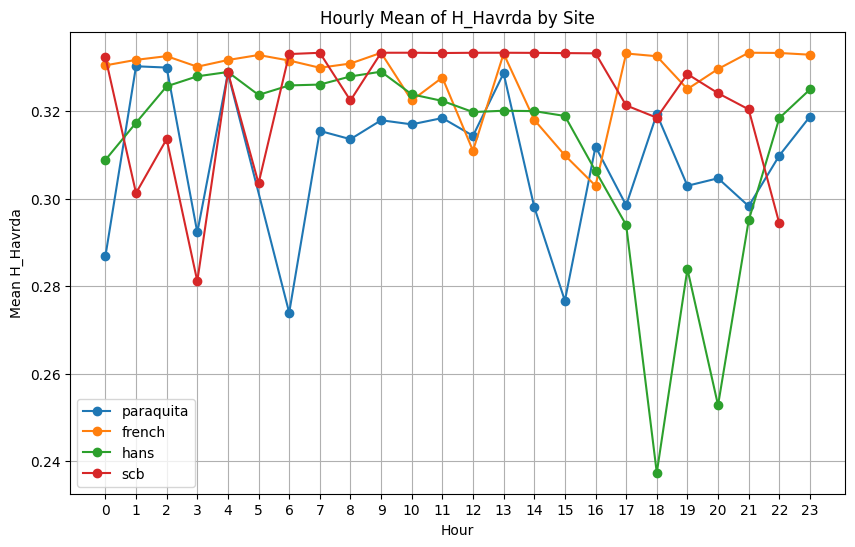

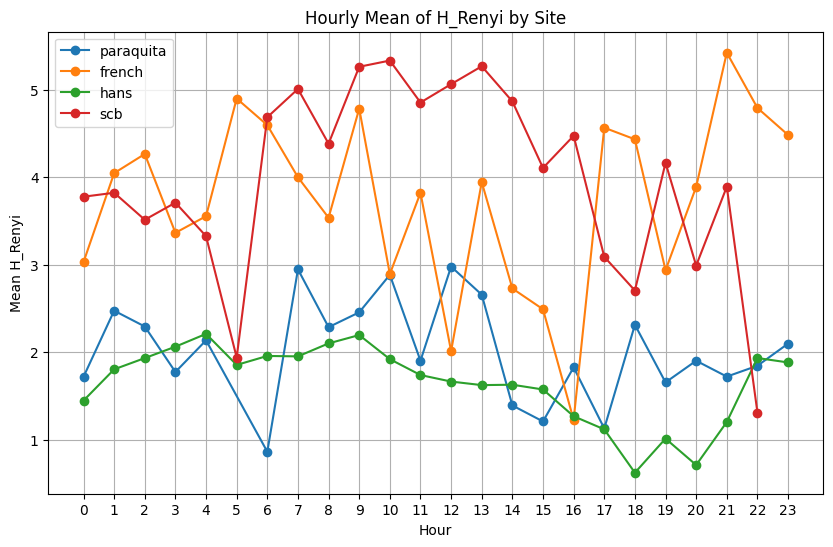

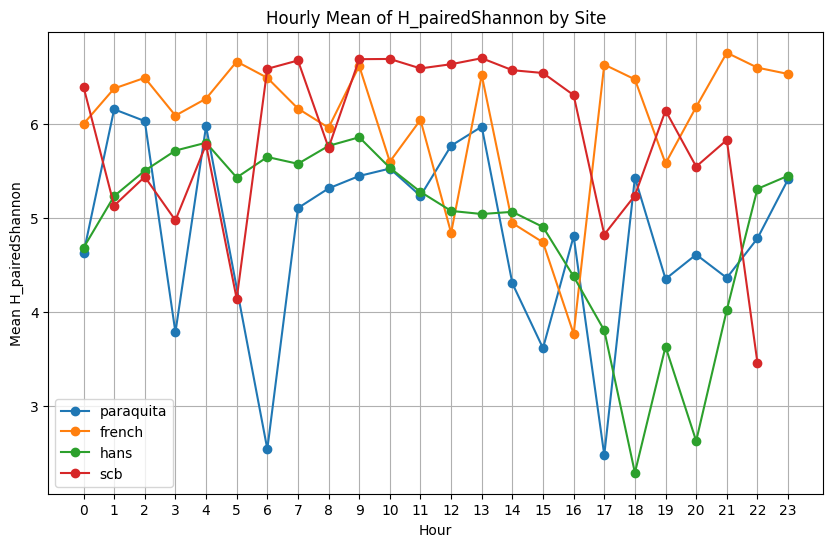

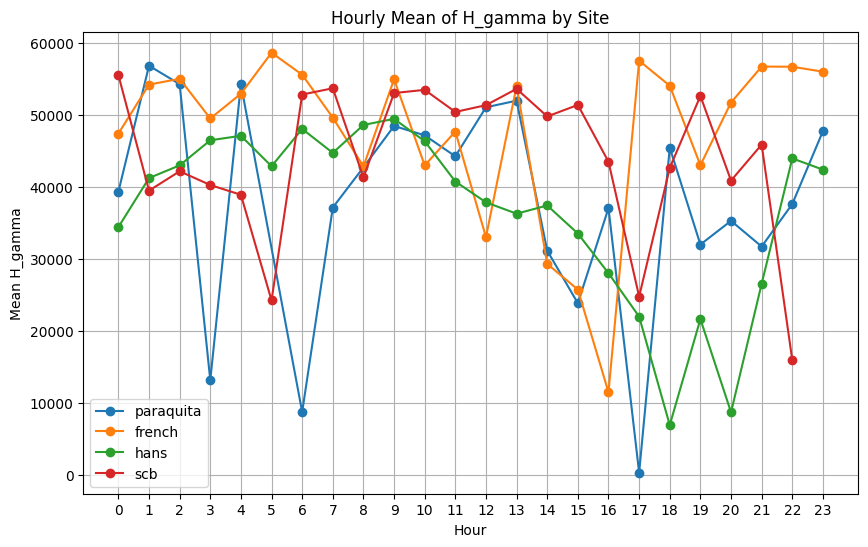

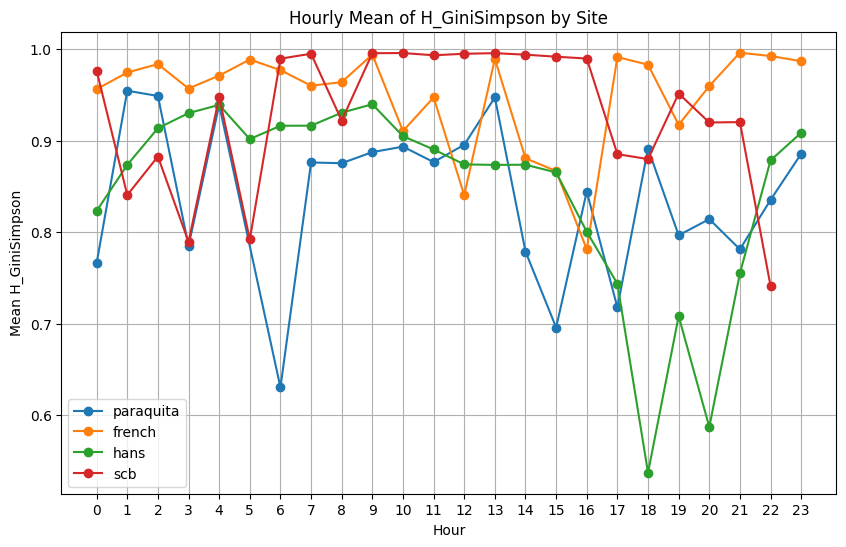

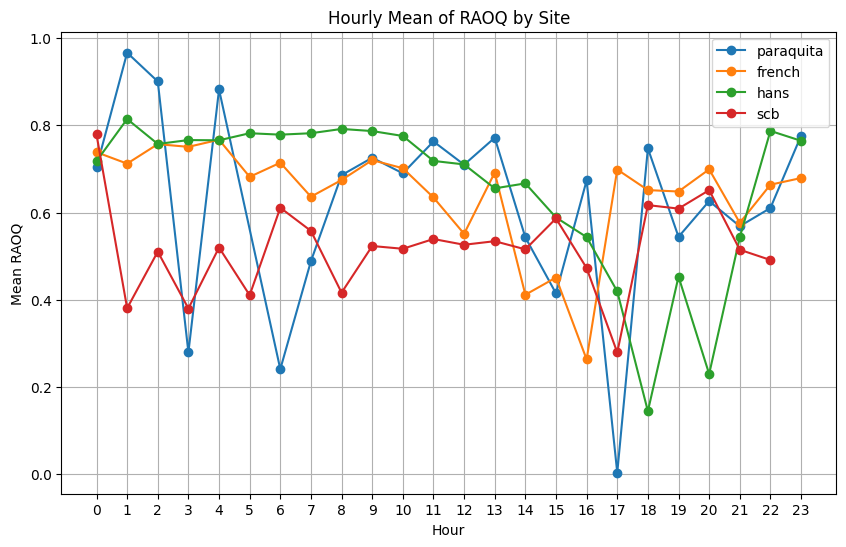

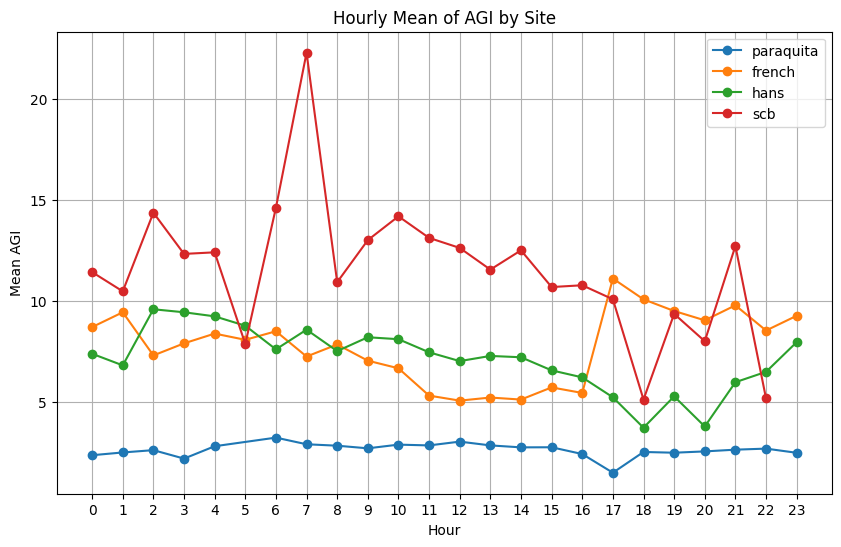

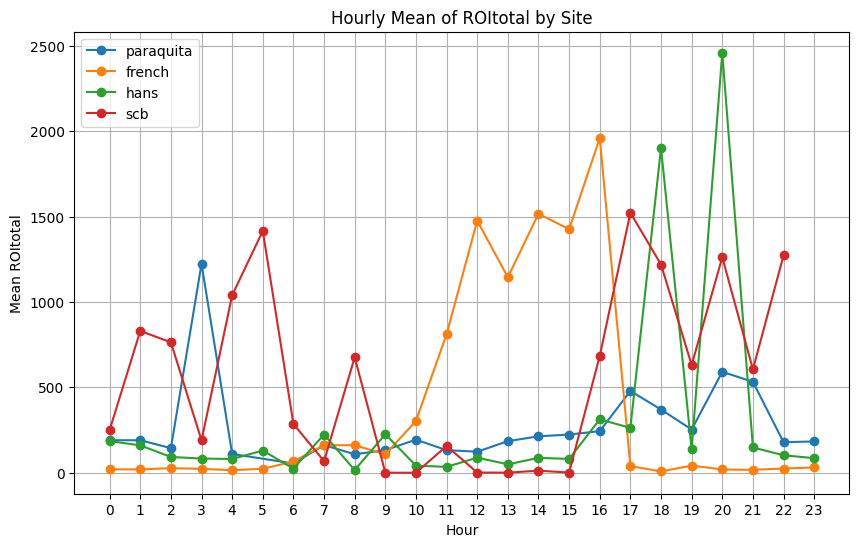

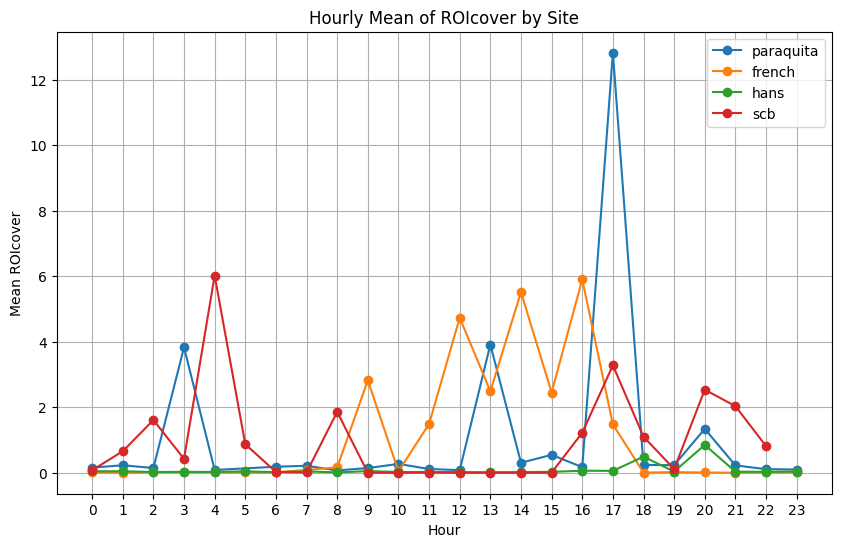

TypeError: agg function failed [how->mean,dtype->object]

<Figure size 1000x600 with 0 Axes>

In [112]:
# Loop through each index and create a plot comparing sites
for index_col in index_columns:
    plt.figure(figsize=(10, 6))  # Create a new figure for each index

    for site_name in site_mapping.values():  # Loop through sites
        site_data = df_indices[df_indices['Site'] == site_name]
        hourly_means = site_data.groupby('Hour')[index_col].mean() # Mean by hour
        plt.plot(hourly_means.index, hourly_means.values, label=site_name, marker='o') # Plot each site

    plt.title(f'Hourly Mean of {index_col} by Site')
    plt.xlabel('Hour')
    plt.ylabel(f'Mean {index_col}')
    plt.xticks(range(24))
    plt.grid(True)
    plt.legend()
    plt.show() # Show the plot

In [113]:
# Group by site and hour and count the number of data points
hourly_counts = df_indices.groupby(['Site', 'Hour']).size().unstack(fill_value=0)

# Print the hourly counts
print("Data Point Counts by Site and Hour:")
print(hourly_counts)

Data Point Counts by Site and Hour:
Hour       0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
Site                                                                            
french      4   3   4   5   4   7   5   3   3   4   4   3   3   4   5   5   4   
hans        8   3   4   3   7   4   2   7   4   5   6   6   3   3   5   3   4   
paraquita   3   4   1   4   2   0   1   6   6   6   4   9   4   6   4   6   4   
scb         6   3   6   3   3   4   6   5   5   8   2   4   9   6   3   1   5   

Hour       17  18  19  20  21  22  23  
Site                                   
french      6   3   3   6   1   5   6  
hans        6   2   4   2   3   3   3  
paraquita   1   7   3   7   4   3   5  
scb         2   3   4   5   5   2   0  


In [114]:
for folder in folders:
    df = date_parser(folder, dateformat='%Y%m%d_%H%M%S', verbose=False)
    print(f"Folder: {folder}, DataFrame Length: {len(df)}")

Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6863_Paraquita/6863_Paraquita_SoundFiles, DataFrame Length: 2152
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6879_French/6879_French_SoundFiles, DataFrame Length: 2358
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6880_HansA/6880_HansA_SoundFiles_Corrected, DataFrame Length: 1736
Folder: /Volumes/SeaBABELa/BVI Mangroves_2024/BVI Mangroves_2024_Working/6884_SeaCowBay/6884_SeaCowBay_SoundFiles, DataFrame Length: 2452


In [115]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df_indices.dtypes)

file                       object
ZCR                       float64
MEANt                     float64
VARt                      float64
SKEWt                     float64
KURTt                     float64
LEQt                      float64
BGNt                      float64
SNRt                      float64
MED                       float64
Ht                        float64
ACTtFraction              float64
ACTtCount                   int64
ACTtMean                  float64
EVNtFraction              float64
EVNtMean                  float64
EVNtCount                 float64
MEANf                     float64
VARf                      float64
SKEWf                     float64
KURTf                     float64
NBPEAKS                     int64
LEQf                      float64
ENRf                      float64
BGNf                      float64
SNRf                      float64
Hf                        float64
EAS                       float64
ECU                       float64
ECV           

In [89]:
# Export the DataFrame to a CSV file for inspection
df_indices.to_csv('df_indices_forapeek.csv', index=False)  # index=False prevents writing the index column